# Machine learning for texts: Junky Union - Classic movies community

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. 

We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. 

It will need to have an F1 score of at least 0.85.

### Data Description



The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:

``review``: the review text

``pos``: the target, '0' for negative and '1' for positive

``ds_part``: 'train'/'test' for the train/test part of dataset, correspondingly

## Initialization

In [9]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re 

from sklearn.dummy import DummyClassifier
import lightgbm as lgb
import xgboost as xgb

In [10]:
#import libraries
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josef\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\josef\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [13]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [14]:

#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz --user

In [15]:
#pip install nltk

In [17]:
#pip install torch


In [18]:
#pip install transformers

In [19]:
#pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [20]:
import spacy


## 0. Load Data

In [21]:

# Load dataset into a Dataframe
try:
    df=pd.read_csv('c:/Users/josef/Practicum/Machine learning for texts/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


In [22]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [23]:
#print size 
df.shape

(47331, 17)

In [24]:
#print % of missing values
df.isna().sum()/len(df)*100

tconst             0.000000
title_type         0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
end_year           0.000000
runtime_minutes    0.000000
is_adult           0.000000
genres             0.000000
average_rating     0.004226
votes              0.004226
review             0.000000
rating             0.000000
sp                 0.000000
pos                0.000000
ds_part            0.000000
idx                0.000000
dtype: float64

## 1. Pre-Process Data

#### 1) a) skip NaN

As there are no missing values in reviews, we will not deal with them because the main goal of this project is to classify reviews in positives and negatives, without taking the rest of features into consideration.


In [25]:
#check for duplicates

df.duplicated().sum()

0

#### 1) b)  Drop useless columns

We'll also drop the columns that are of no use for interpreting the positivity or negativity of reviews


In [26]:
#check for is_adult values distribution
df.is_adult.value_counts()

0    47249
1       82
Name: is_adult, dtype: int64

In [27]:
# drop columns that have no useful info for understanding reviews connotation

df.drop(['title_type','primary_title','original_title','end_year','is_adult','runtime_minutes','genres','idx'], axis=1,inplace=True)
df

,tconst,start_year,average_rating,votes,review,rating,sp,pos,ds_part
0,tt0068152,1971,6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train
1,tt0068152,1971,6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train
2,tt0313150,2002,6.3,184,There is no real story the film seems more lik...,3,neg,0,test
3,tt0313150,2002,6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test
4,tt0313150,2002,6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test
...,...,...,...,...,...,...,...,...,...
47326,tt0068398,1972,7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test
47327,tt0223503,1996,7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test
47328,tt0223503,1996,7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test
47329,tt0223503,1996,7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test


In [28]:
#check that SP and POS are consistent

df.groupby('sp')['pos'].value_counts()

sp   pos
neg  0      23715
pos  1      23616
Name: pos, dtype: int64

In [29]:
#check that rating is aligned with pos/neg review

df.groupby('sp').agg({'rating':['min', 'max']})

rating    
       min max
sp            
neg      1   4
pos      7  10

## Data pre-processing - summary

As part of the data wrangling process, we:

1) Ignored missing values in ``votes`` and ``average rating``because those features won't be used in this project.

3) Removed useless columns.

4) Ensured that sp and pos columns had consistent values in every row.

5) Ensured that the rating column was aligned with the two abovementioned columns.

## 2. EDA

Let's check the number of movies and reviews over years.

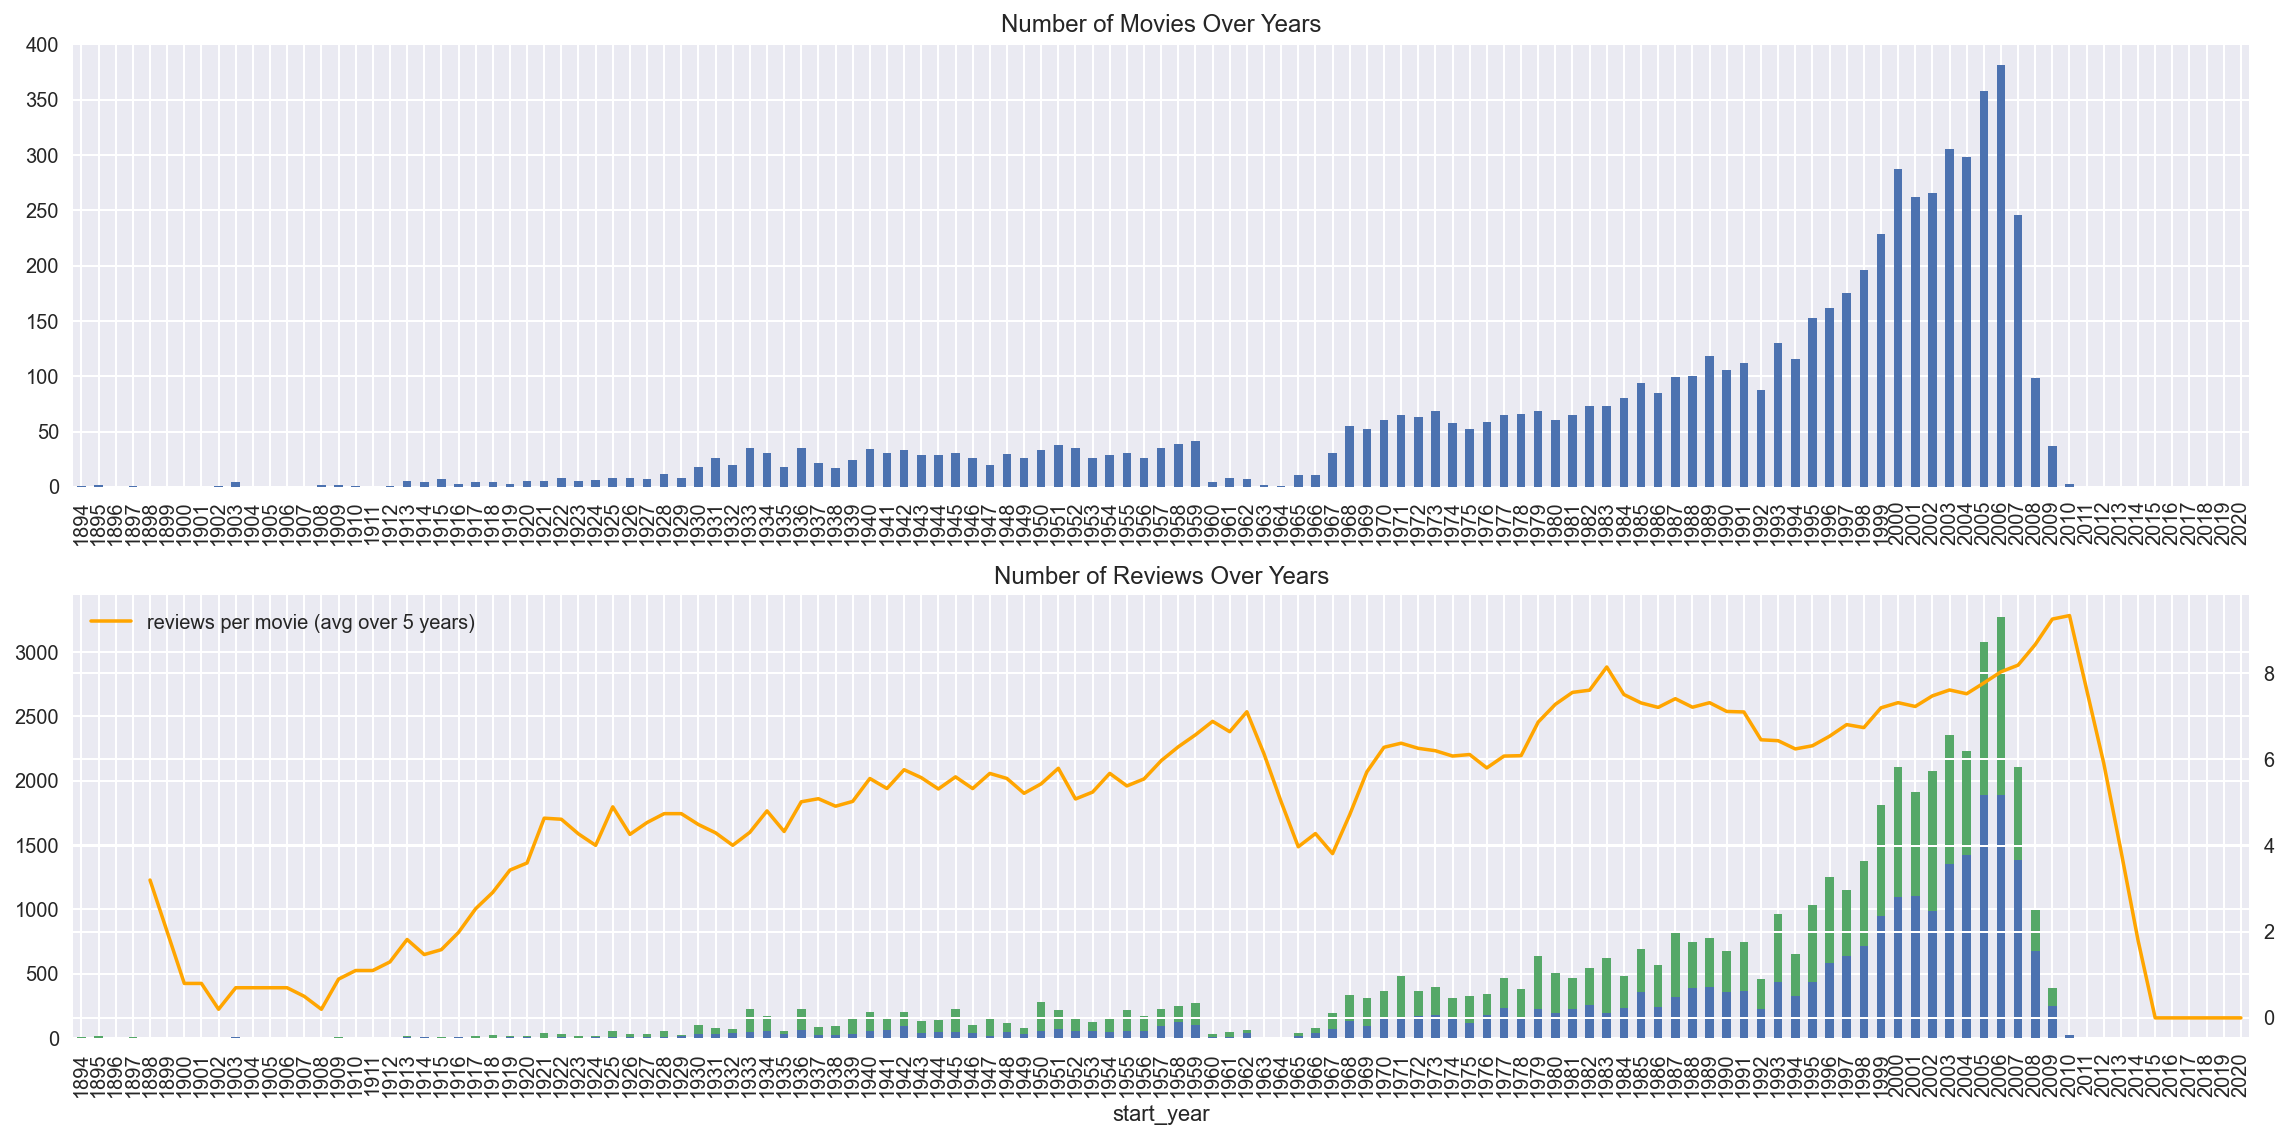

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

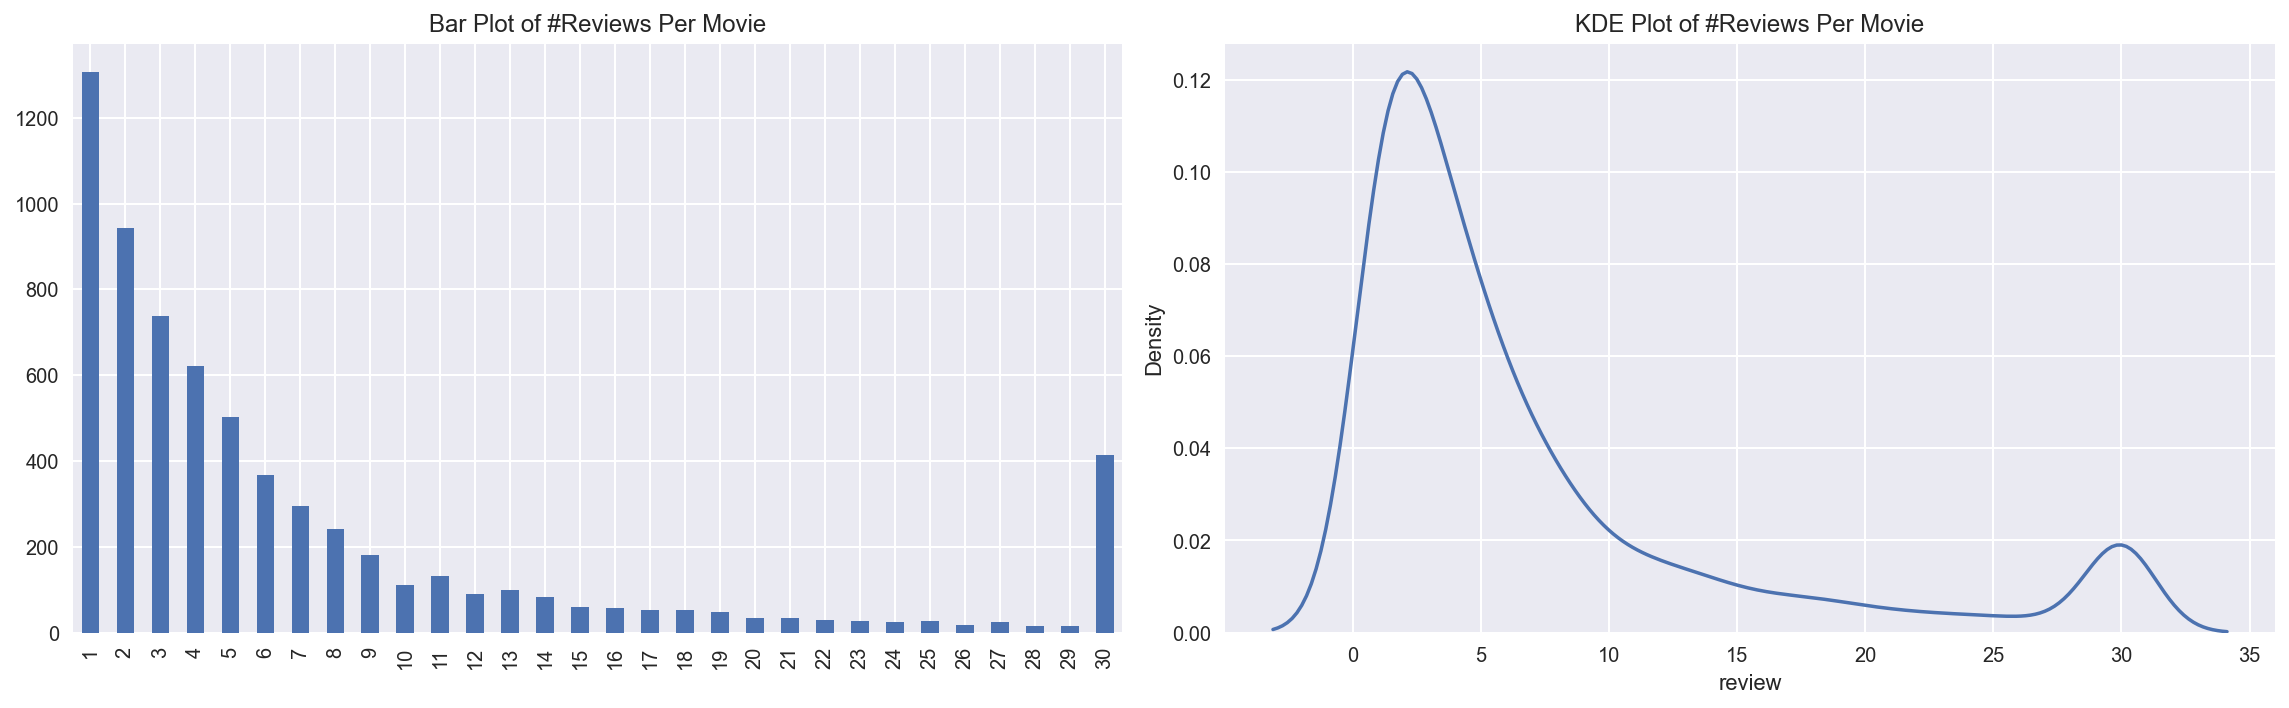

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [32]:
df['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

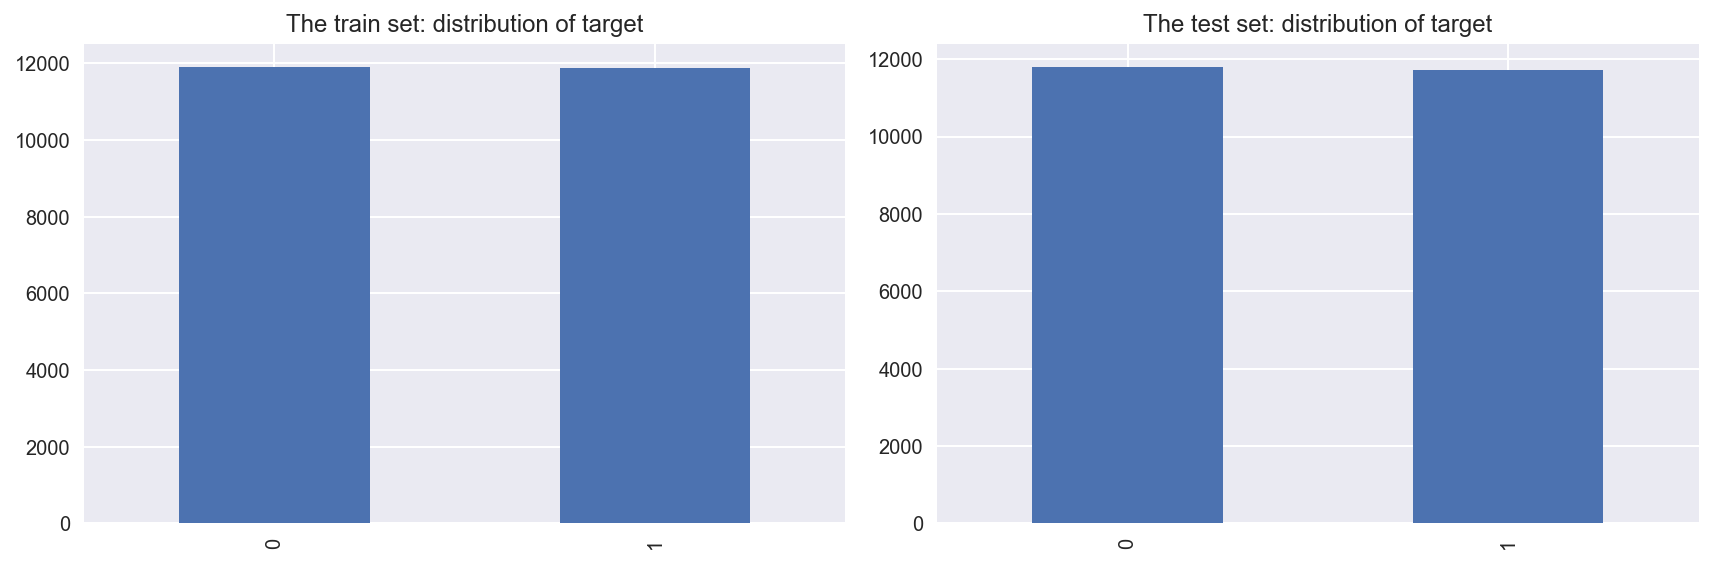

In [33]:
#plot distribution of target values in test and train set

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['pos'].value_counts().sort_index()

dft.plot.bar(ax=ax)

ax.set_title('The train set: distribution of target')

ax = axs[1]
dft = df.query('ds_part == "test"')['pos'].value_counts().sort_index()

dft.plot.bar(ax=ax)

ax.set_title('The test set: distribution of target')

fig.tight_layout()

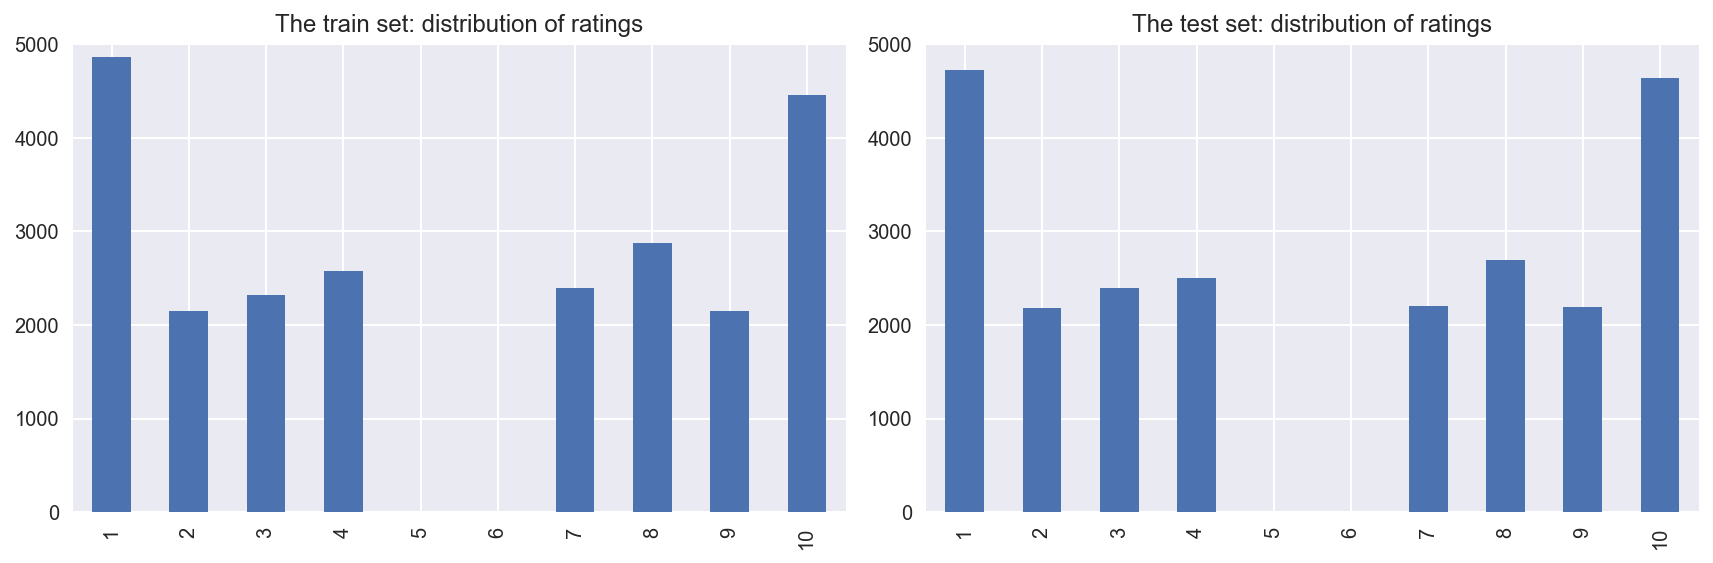

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

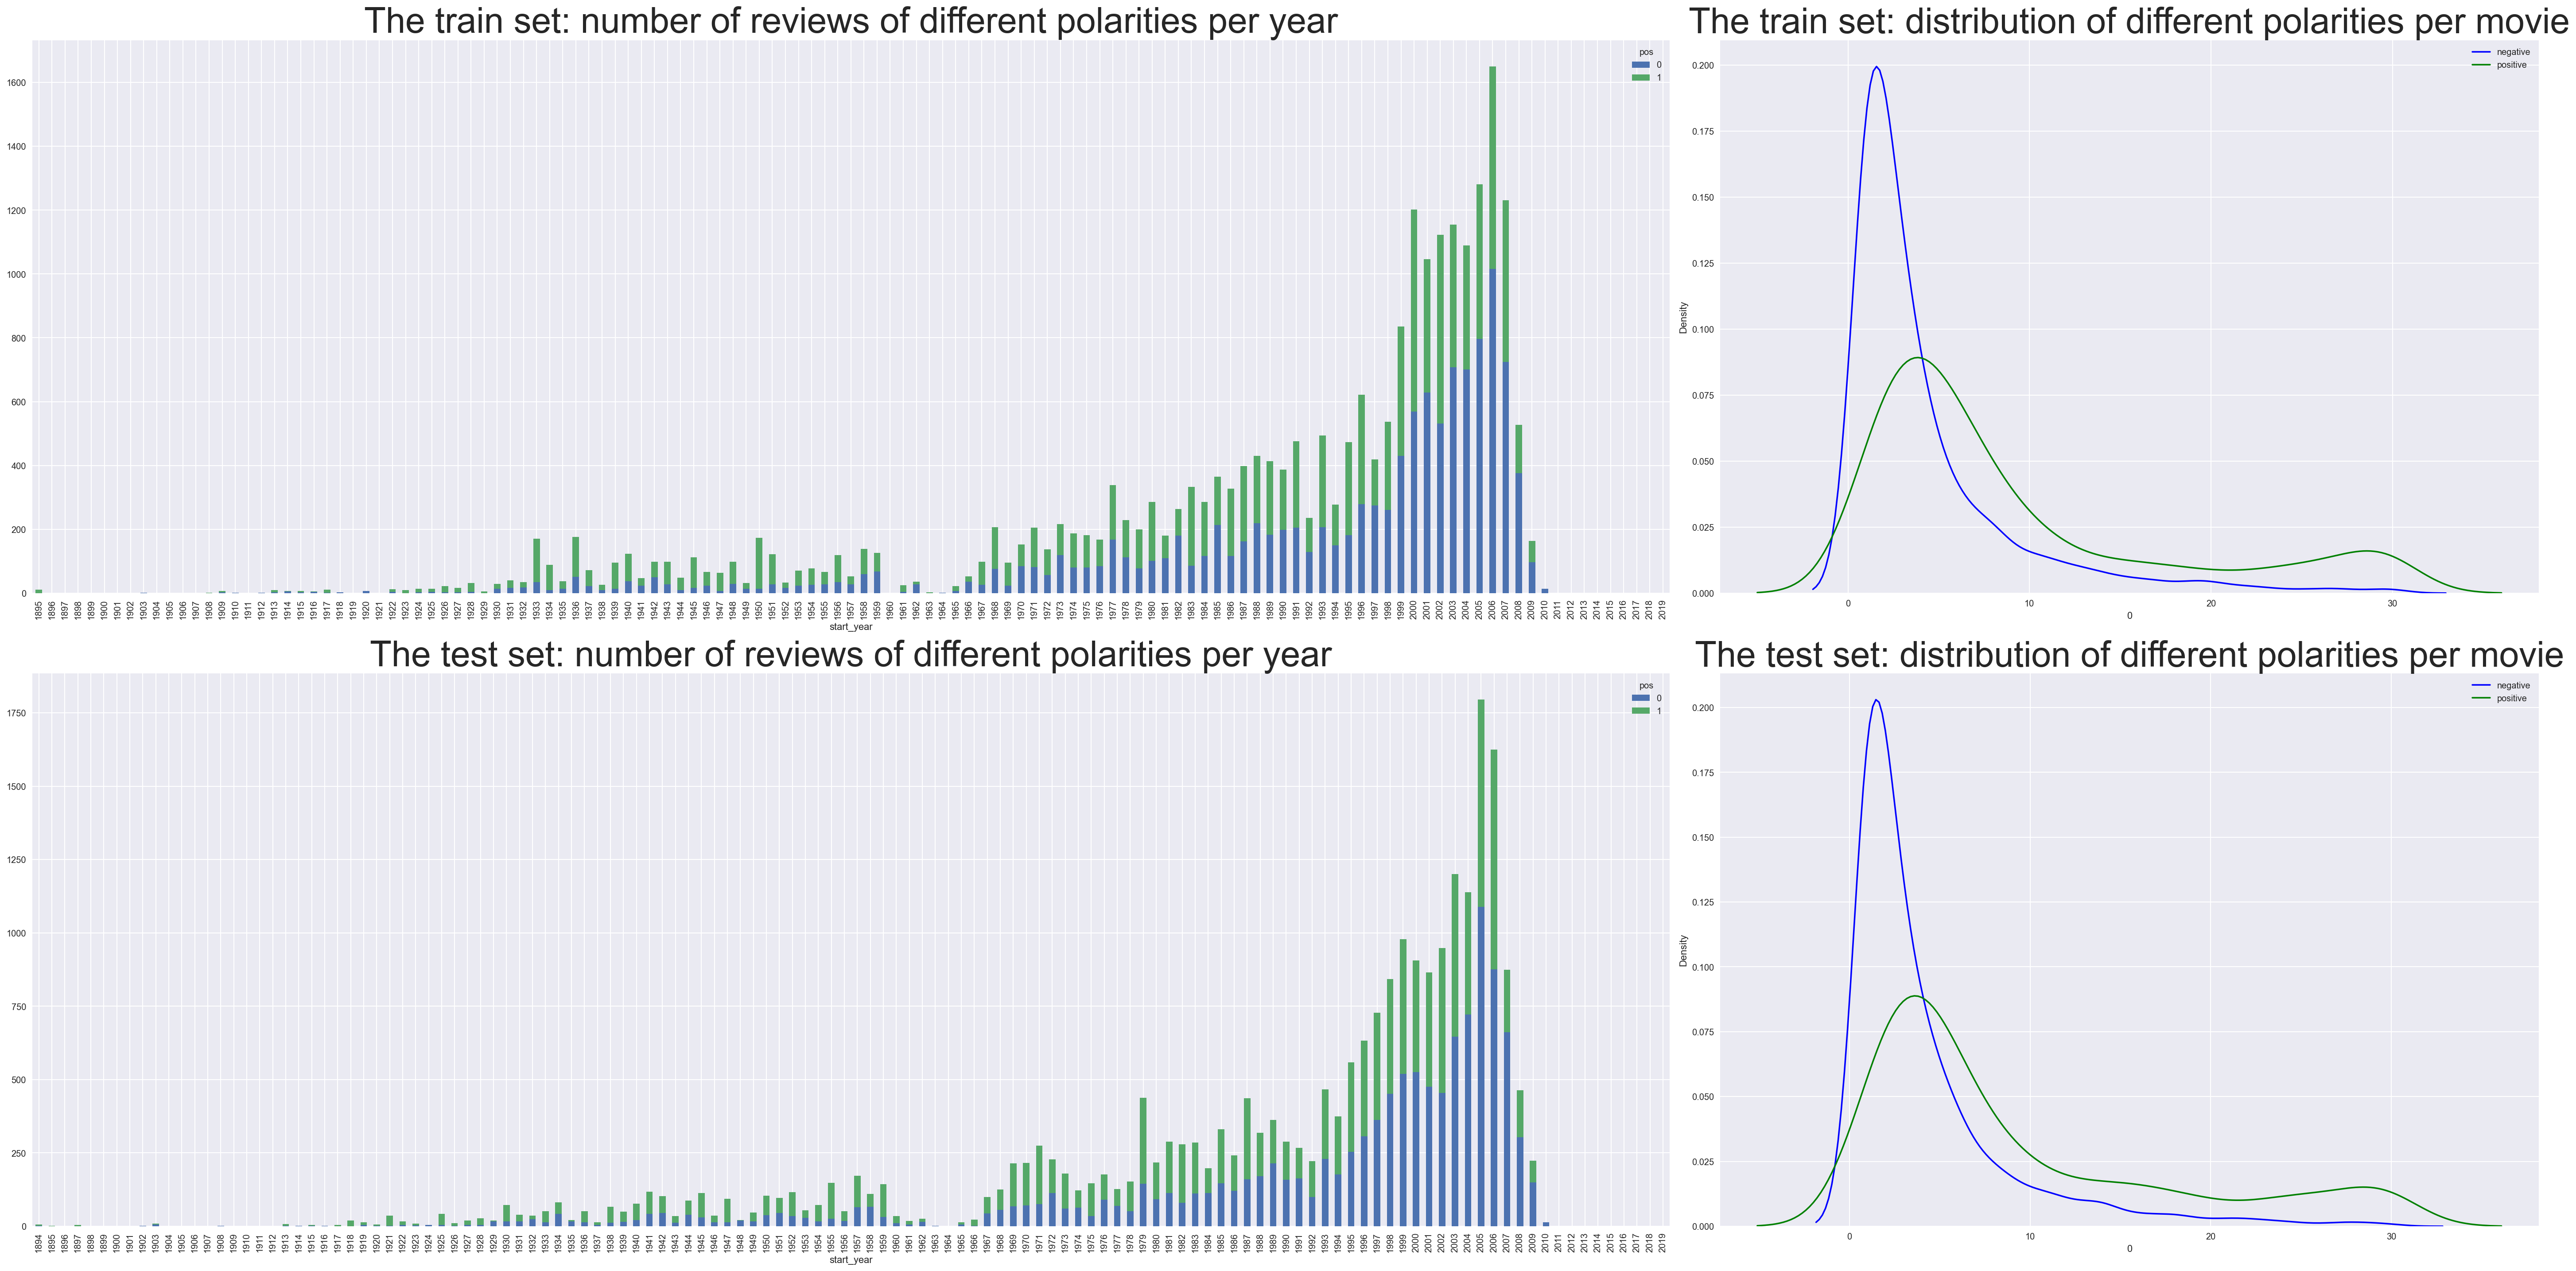

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(40,20), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year', fontsize = 40)

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie', fontsize = 40)

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year', fontsize = 40)

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie', fontsize = 40)

fig.tight_layout()

### EDA - Summary

From the charts plotted above, we can draw the following conclusions:

1) The amount of movies released for which reviews have been published has increased significantly in the period between 1995-2007, but has practically gone to 0 from 2010 onwards. This is probably the year in which series portals such as Netflix started replacing the cinema and video rental industry. 

2) As for the distribution of number of reviews per movie, we can see that there are few popular movies with a larger count of reviews. Except for the 30 movies with 400 reviews each, we can see the count of movies with more reviews decreases from left to right (i.e. there are 1200 movies with only 1 review, and less than 50 movies with 29 reviews).

3) The distribution of ratings is consistent between the train and test set: negative reviews' ratings range from 1-4 and positives' from 7-10. There's a larger count of reviews with a rating of 10 among positive reviews, as well as of 1 for negative reviews. This means that people tend to assign determinant scores.

4) As for the distribution of polarities over the years, we see that from 1922 to 1995 there were fewer movies launched and reviewed, and there was in general a more negative proportion among those reviews. There onwards and up until 2010, the amountf movies released hikes up and also does the proportion of positive reviews.

5) Regarding the class imbalance of the target (pos), we can say that the set is perfectly balanced (overall, and in the train & test sets), as the positive reviews (1) are almost as high as the negative ones (0): 23,614 vs 23,715 in the entire set, and roughly 12 k reviews of each kind in both sets.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [36]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    model.fit(train_features, train_target)
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## 3. Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

### Remove extra spaces and characters other than letters and apostrophes

We will use regular expressions to create a pattern of the characters we want to keep (letters and apostrophes), preceeded by a ^ sign (means "not"). Then we'll replace every character not corresponding to that pattern by an empty string ("").

To get rid of extra spaces, we will split the text and then recombine it back into a string with spaces.



In [37]:
#create function to remove every character not corresponding to a letter or apostrophe, as well as extra spaces
def clear_text(text):
    
    # < write code here >
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text.lower())
    text= text.split()
    text= " ".join(text)
    return text

In [38]:
df['review_norm'] = df['review'].apply(clear_text)

df.head()

,tconst,start_year,average_rating,votes,review,rating,sp,pos,ds_part,review_norm
0,tt0068152,1971,6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,the pakage implies that warren beatty and gold...
1,tt0068152,1971,6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,how the hell did they get this made presenting...
2,tt0313150,2002,6.3,184,There is no real story the film seems more lik...,3,neg,0,test,there is no real story the film seems more lik...
3,tt0313150,2002,6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,um a serious film about troubled teens in sing...
4,tt0313150,2002,6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,i'm totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [39]:
#split df into train and test
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

#select target column
train_target = df_train['pos']
test_target = df_test['pos']

print(df_train.shape)
print(df_test.shape)

(23796, 10)
(23535, 10)


## Working with models

As explained in the introduction, the metric we will focus on for evaluating model performance is the F1 score, aiming to achieve a rate of at least 0.85.

For context the F1 score combines precision and recall, which separately are not very informative:

RECALL = TRUE POSITIVES / (TRUE POSITIVES + FALSE NEGATIVES) - (% of real positives that were guessed by the model)

PRECISION = TRUE POSITIVES / ( TRUE POSITIVES + FALSE POSITIVES) - ( % of positives predicted that were correct)


The whole point of improving model performance is to simultaneously increase the value for both metrics. F1 score is intended to find the point where the optimal balance between them is achieved.

For instance, a model pedicting always a positive answer, would get a 100% in Recall (as false negatives would be = 0), but a low precision. On the other hand, a model making too many negative predictions would score very low at both, because the numerator would be 0.


F1 Score combines recall and precision as follows:

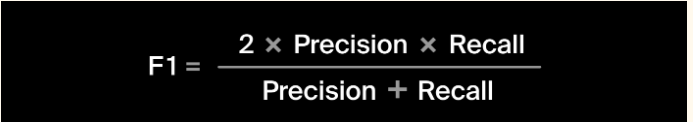




### Model 0 - Constant

In [40]:
#define a model predicting a constant value
model_dummy_negative= DummyClassifier(strategy='constant', constant=0)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


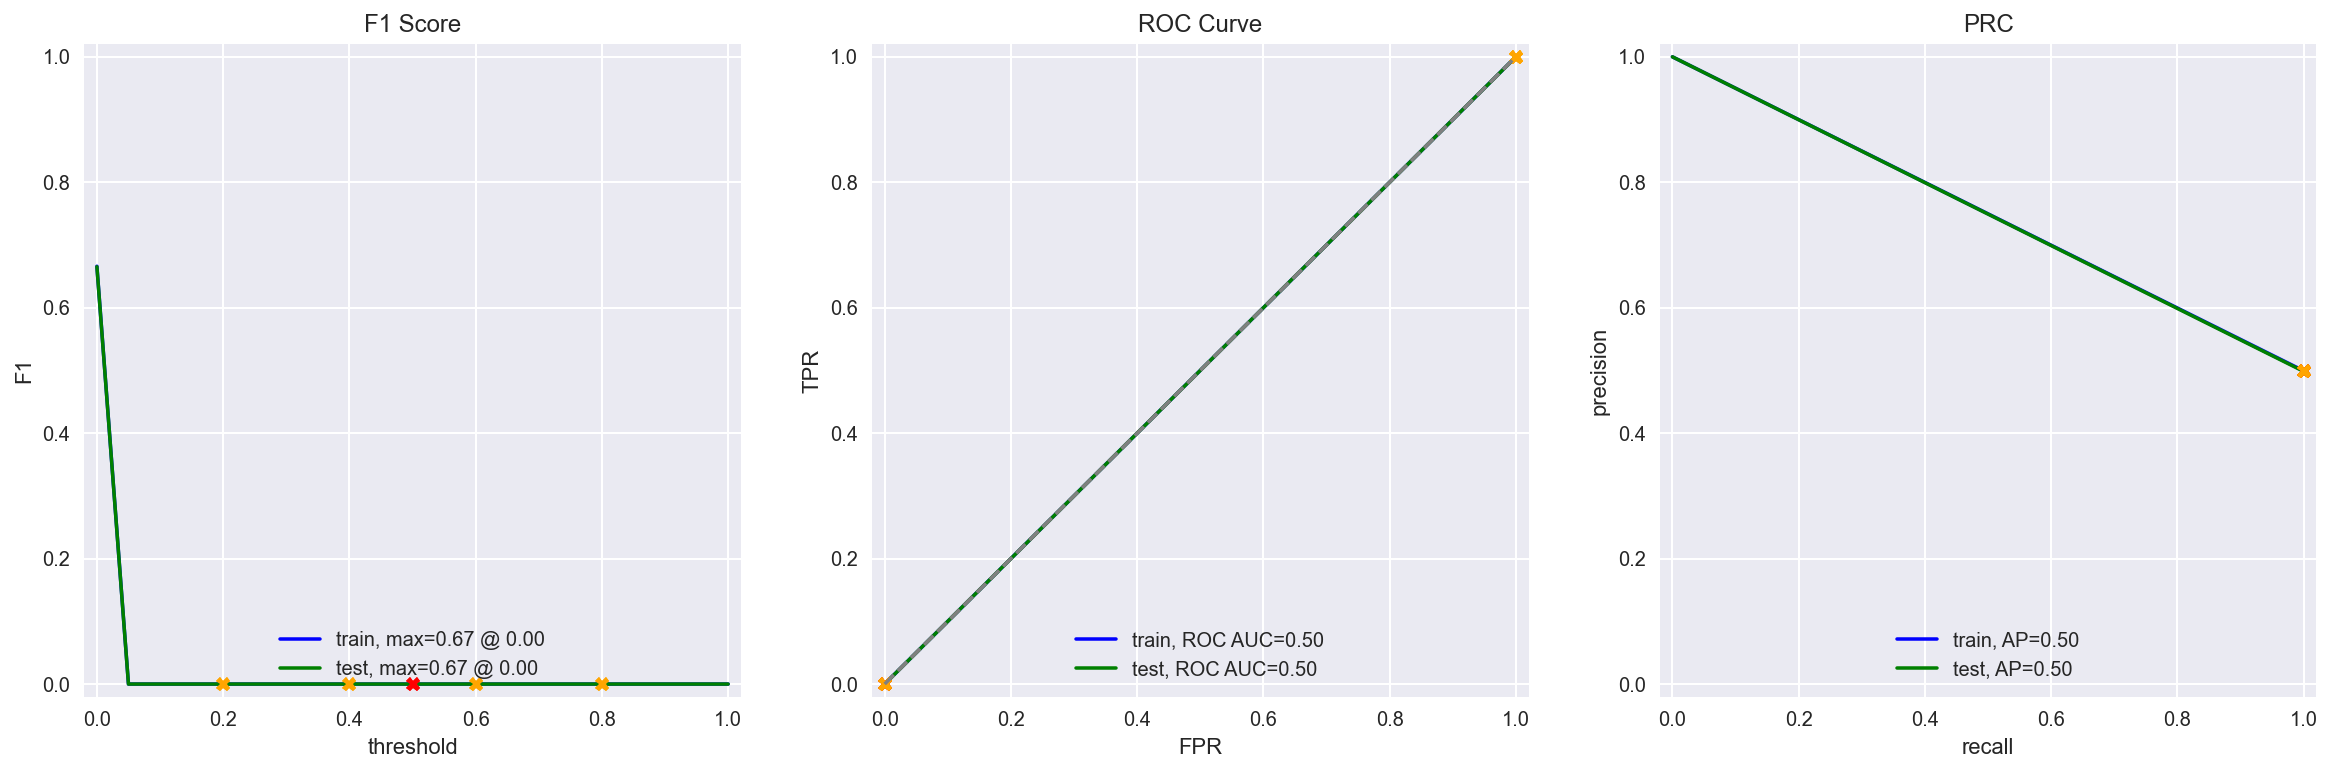

In [41]:
#evaluate a model always predicting 0 (negative review)
evaluate_model(model_dummy_negative, df_train['review_norm'], train_target, df_test['review_norm'], test_target)

In this case, as we have an almost perfect class balance (there are almost the same amount of positive and negative target values both in the train & test sets), a model predicting always a TRUE or FALSE value would have a 0.50 Accuracy and APS (50% of its predictions would match the real value).


Regarding the f1 score, as detailed above, both precision and recall are 0.00 in this scenario, so F1 score is also 0 (in fact, we cannot divide by 0, but when the denominator = 0, we equal the result to it).


In [42]:
#evaluate a model always predicting 1 (positive review)
model_dummy_positive= DummyClassifier(strategy='constant', constant=1)

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


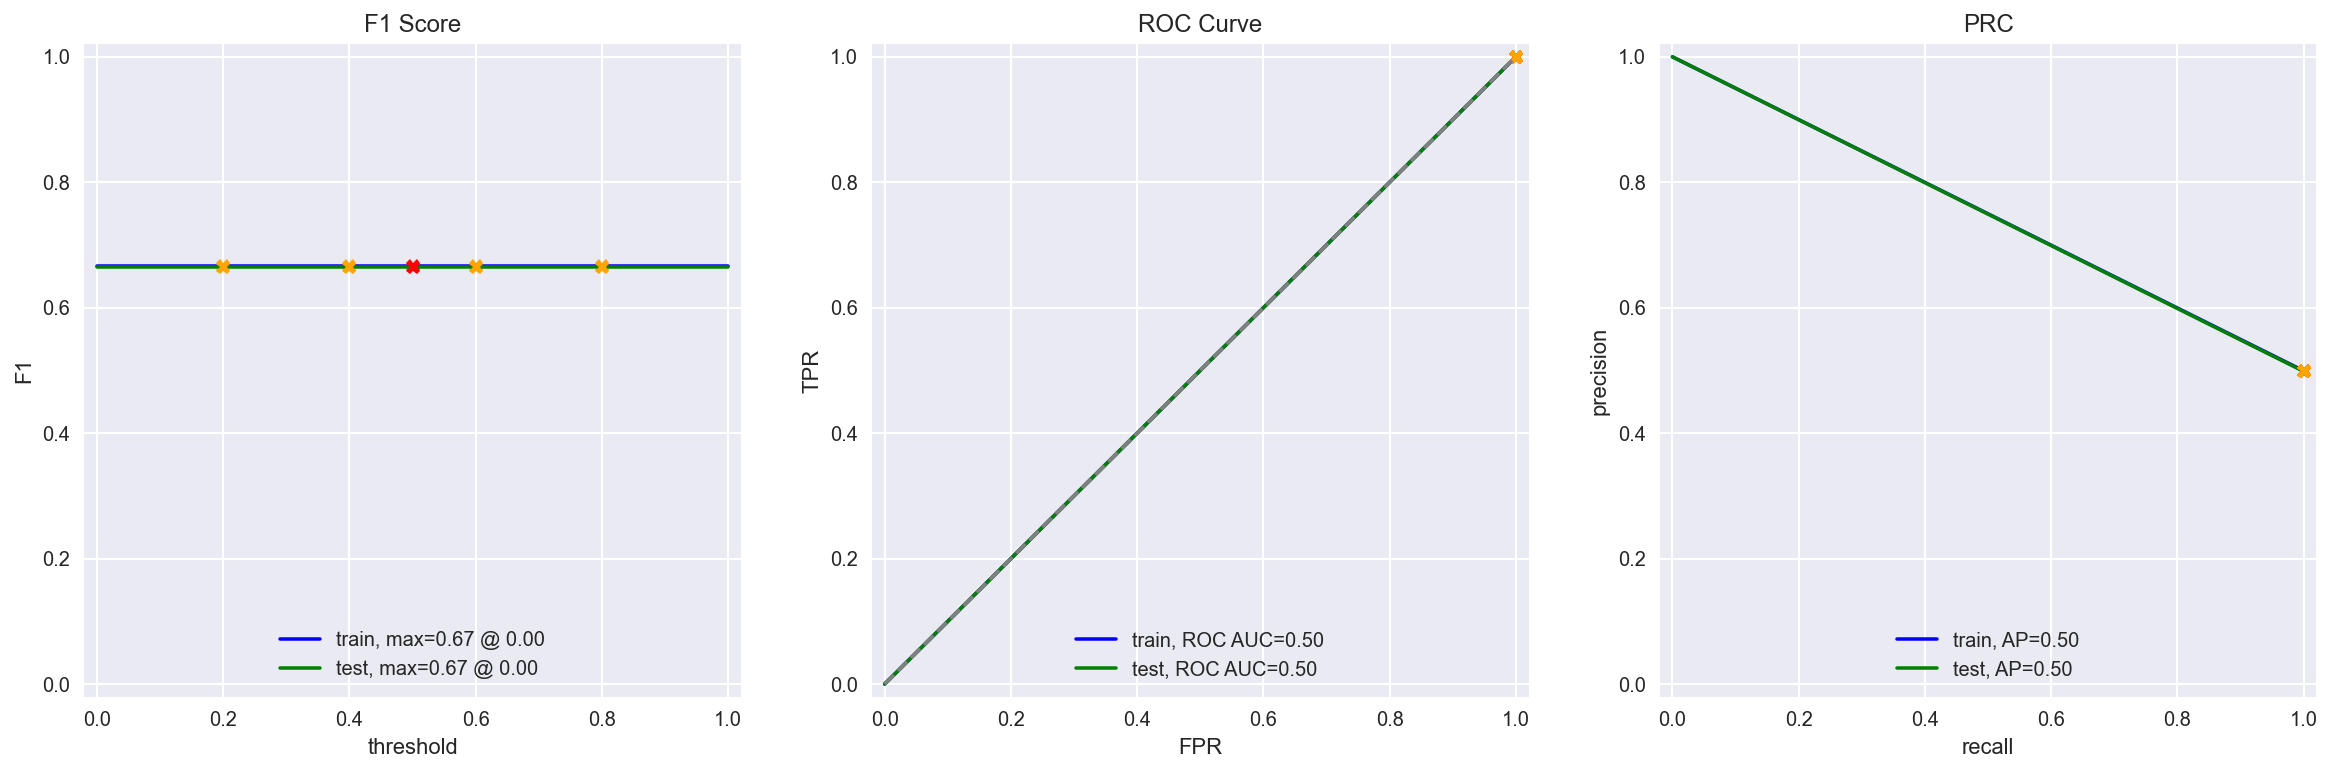

In [43]:
evaluate_model(model_dummy_positive, df_train['review_norm'], train_target, df_test['review_norm'], test_target)

Every metric other than the f1 score is 0.50, and he f1 score is 0.67 since:
 
RECALL = TRUE POSITIVES / (TRUE POSITIVES + FALSE NEGATIVES) = TRUE POSITIVES / TRUE POSITIVES = 1 [no false negatives]

PRECISION = TRUE POSITIVES / ( TRUE POSITIVES + FALSE POSITIVES)= 0.50  [half of positives are correct]

What gives us:

F1= ( 2 x 1 x 0.5]) / (2+1+0.5)= 0.67


On another note, for a model that always answers randomly, the ROC curve is a diagonal line going from the lower left to the upper right. This is the case in both of the constant models (The AUC-ROC value for a random model is 0.5)


## Training ML models

Now that we know that a model constantly predicting 1(True) would achieve a 0.67 F1 score on the test set, we will compare such result to the ones achieved by different trained ML models:

- Logistic Classification
- Light GBM Classifier
- XG Boost Classifier


Since models can only be trained with numbers, we will convert the reviews into arrays containing the TF-IDF (Term Frequency — Inverse Document Frequency) of each word contained in every review from the train set.

Here's the formula for TF-IDF:

$TF =  T / N$

 t (term) is the number of word occurrences and n is the total number of words in the text.
 
 
$IDF = log_{10} (D/d)$ 

 (D) is the total number of texts in a corpus  and d are the number of texts where the word occurs.
 
 

We will also try with implementing ngrams = (2,2) for counting pairs of words instead of unique words, and see if that helps the models improving their performance due to emphatizing the connotation of words that are normally used together.



### 3.2. Lemmatization 

As said above, before extracting features, we're going to have to simplify the text. This'll help make the text easier to handle due to variations of word forms.

Here are the steps for text preprocessing:

- Tokenization: you'll need to divide the text into tokens (separate phrases, words, and symbols);
- Lemmatization: you'll need to reduce the words to their root forms (lemma).

We will try these libraries for both tokenization and lemmatization:

1) Natural Language Toolkit (NLTK)

2) spaCy


3) Finally, we will train a BERT model using 750 reviews from the train set (since it needs many computational resources, it is not feasible to use the whole dataset) and assess the score that it manages to get on 750 reviews from the test set.

This algorithm is capable of "understanding" the context of a whole text, not just short phrases. BERT is frequently used in machine learning to convert texts into vectors. 

When processing words, BERT takes into account both immediate neighbors and more distant words. This allows BERT to produce accurate vectors with respect to the natural meaning of words.

This is how it works:

- Here's an example of an input for the model: "The red beak of the puffin [MASK] in the blue [MASK]" where MASK represents unknown or masked words. The model has to guess what these masked words are.

The model learns to figure out whether the words in the sentence are related. We had the words "flashed" and "sky" masked. The model has to comprehend that one word follows the other. So, if we hid the word "crawled" instead of "flashed", the model wouldn't find a connection.


## NLTK & TF-IDF 

In [44]:

#define function to lemmatize text
def nltk_lemmatize(text):

    #initialize an object of the class WordNetLemmatizer()     
    lemmatizer  = WordNetLemmatizer() 
    
    #store a set of stop words
    stop_words = set(stopwords.words('english'))
    
    #define a tokenizer
    tokens = word_tokenize(text.lower())
    
    #lemmatize the tokenized text excluding stopwords storing each lemmatized word in a list
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words] 
    
   
    #join the elements in the list separating them with a space
    return " ".join(lemmas) 

In [45]:
#test function on second review
nltk_lemmatize(clear_text(df.loc[1,'review']))

"hell get made presenting caper comedy misbegotten essentially two hour people mumbling sentence fragment usually dependable warren beatty look drunk usually hilarious goldie hawn act like 's depressant gert frobe famous role goldfinger infinitely admirable character even guy champagne bottle lsd save litany worthlessness comparing movie plan outer space would n't thing even someone paid p fo idiotically made ended hilarious idiotically made cause feel like brain melted ear warren beatty goldie hawn made co starred shampoo co starred dreadful town country maybe n't co star movie would rather skin torn watch awful maybe remake jackie chan would pay see"

In [46]:
%%time
#apply function to normalized reviews
df_train ['nltk_lemma']= df_train ['review_norm'].apply(nltk_lemmatize)
df_test ['nltk_lemma']= df_test ['review_norm'].apply(nltk_lemmatize)
df_train.head()

Wall time: 42.9 s


,tconst,start_year,average_rating,votes,review,rating,sp,pos,ds_part,review_norm,nltk_lemma
0,tt0068152,1971,6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,the pakage implies that warren beatty and gold...,pakage implies warren beatty goldie hawn pulli...
1,tt0068152,1971,6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,how the hell did they get this made presenting...,hell get made presenting caper comedy misbegot...
7,tt0035958,1943,6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,this true story of carlson's raiders is more o...,true story carlson 's raider army training fil...
8,tt0035958,1943,6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,should have been titled 'balderdash ' little i...,titled 'balderdash ' little film true except n...
9,tt0035958,1943,6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,the movie 'gung ho ' the story of carlson's ma...,movie 'gung ho ' story carlson 's makin island...


In [47]:
#define function to vectorize count of words in review
#if rng is specified, then n-grams will be calculated

def tf_idf(corpus_train, corpus_test, rng= (1,1)):

  
    #define a tdf.idf vectorizer
    if rng != (1,1):
        count_tf_idf = TfidfVectorizer( ngram_range= rng)
    else:
        count_tf_idf = TfidfVectorizer() 
    
    #fit and transform the train set    
    tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
    
    #transform the test set
    tf_idf_test= count_tf_idf.transform(corpus_test)
    
    #return the train and test set as arrays
    return tf_idf_train, tf_idf_test

In [48]:
#define train and test features without calculating ngrams
features_train_nltk, features_test_nltk = tf_idf(df_train ['nltk_lemma'],df_test['nltk_lemma'])


In [49]:
#check array shape
features_train_nltk.shape

(23796, 64399)

In [50]:
#verify that length matches df train length
df_train.shape

(23796, 11)

In [51]:
#ensure the test set has the same amount of features
features_test_nltk.shape

(23535, 64399)

### Model 1) NLTK, TF-IDF and LR 

In [52]:
#define linear model
model_regression= LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


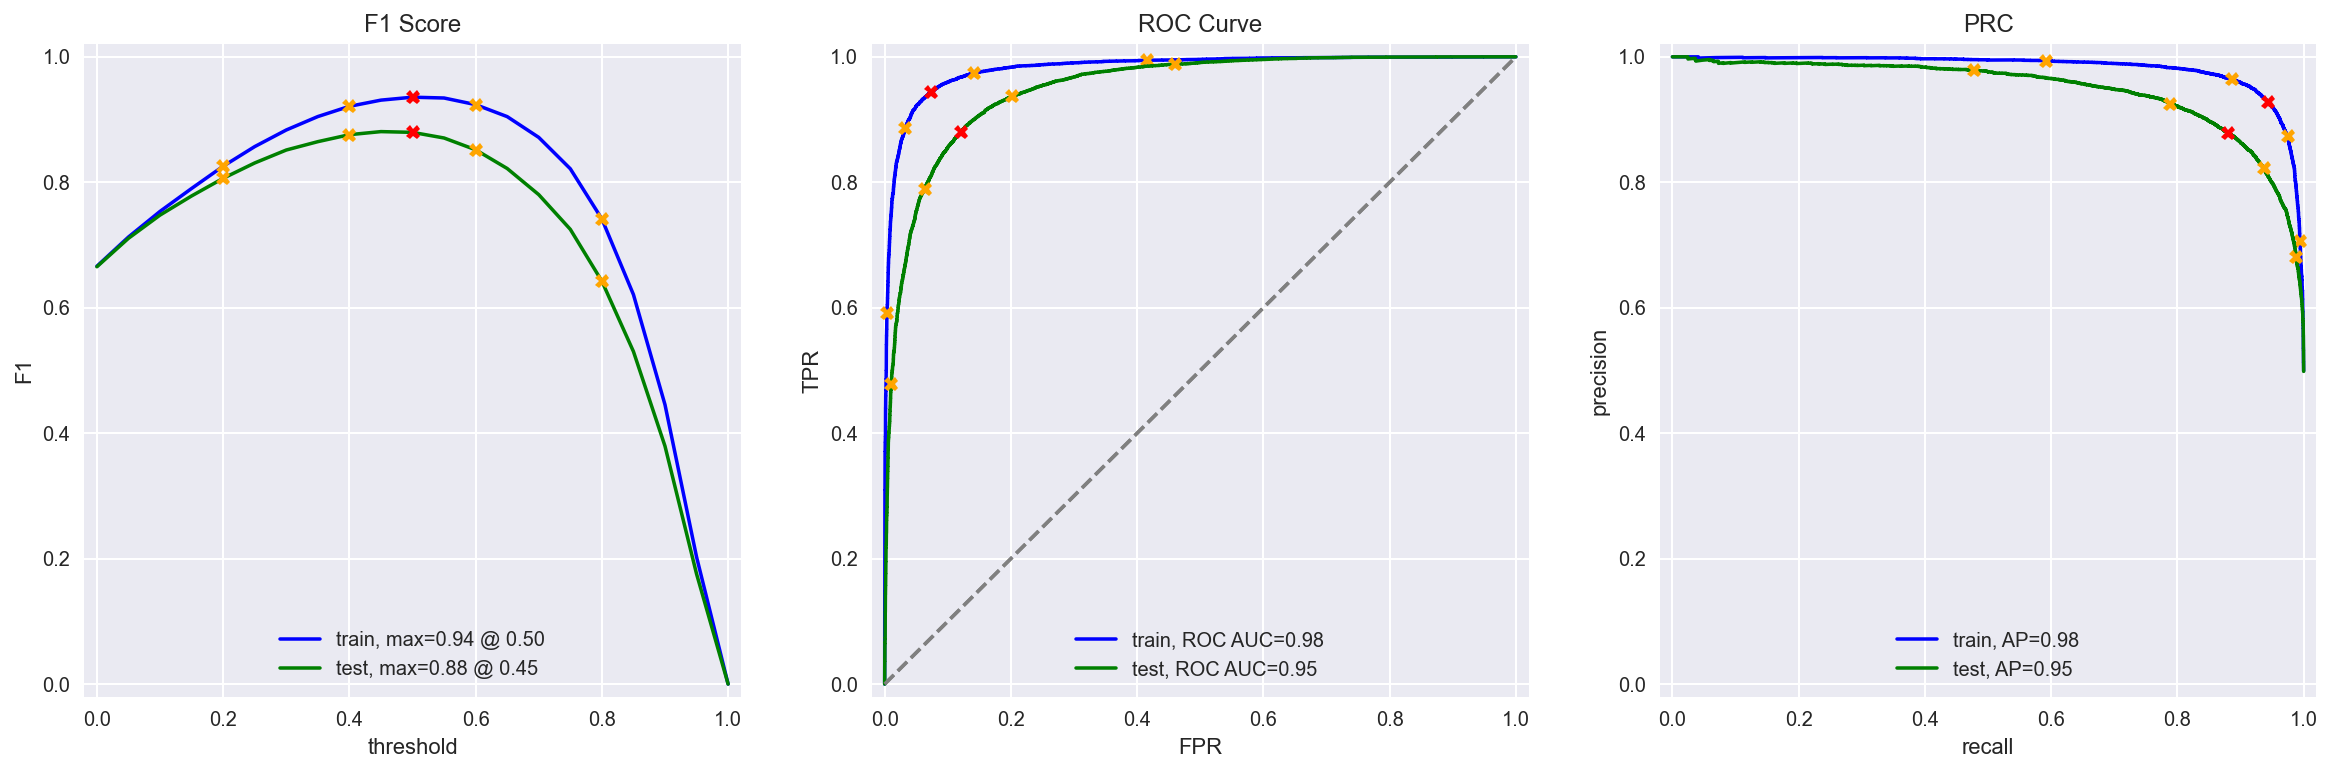

In [53]:
#evaluate model performance
evaluate_model(model_regression, features_train_nltk, train_target, features_test_nltk, test_target)

In [54]:
#define train and test features calculating ngrams = (2,2)
features_train_nltk_ngram, features_test_nltk_ngram = tf_idf(df_train ['nltk_lemma'],df_test['nltk_lemma'], rng=(2,2))

          train  test
Accuracy   0.99  0.84
F1         0.99  0.84
APS        1.00  0.91
ROC AUC    1.00  0.92


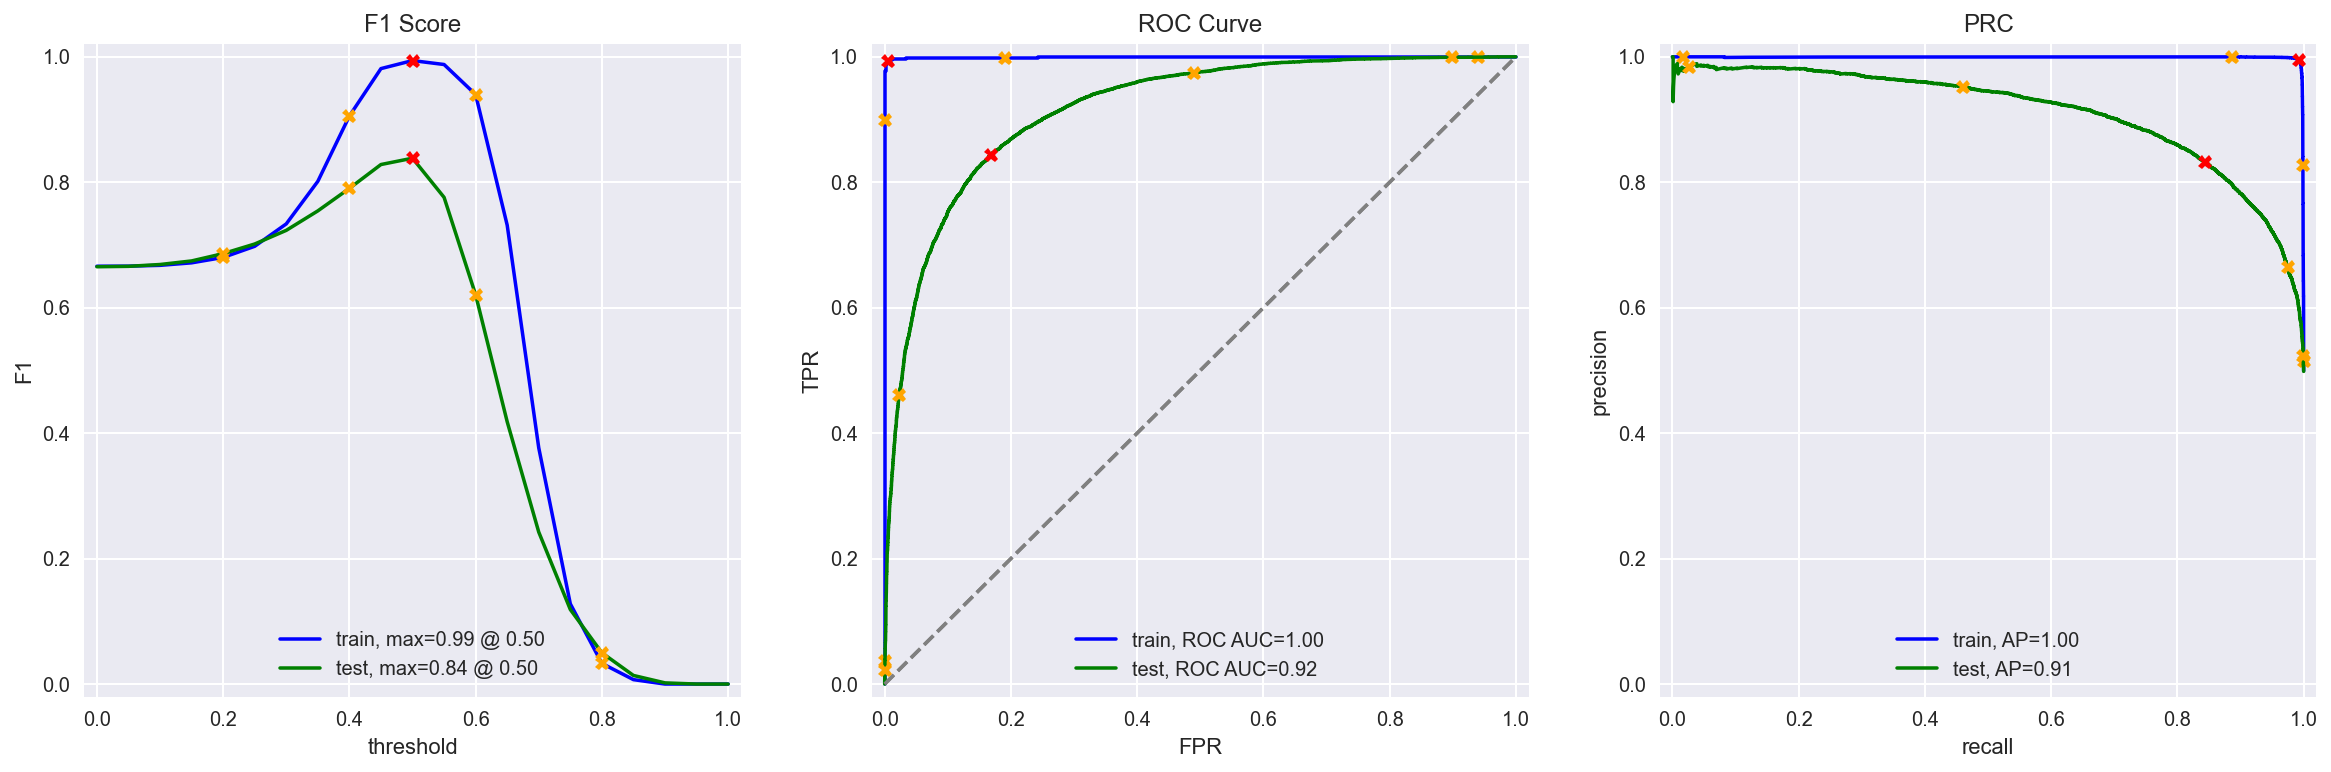

In [55]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_regression, features_train_nltk_ngram, train_target, features_test_nltk_ngram, test_target)

### Model 2) NLTK, TF-IDF and Light GBM

In [56]:
#initialize model
model_light_gbm= lgb.LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.94
ROC AUC    0.97  0.94


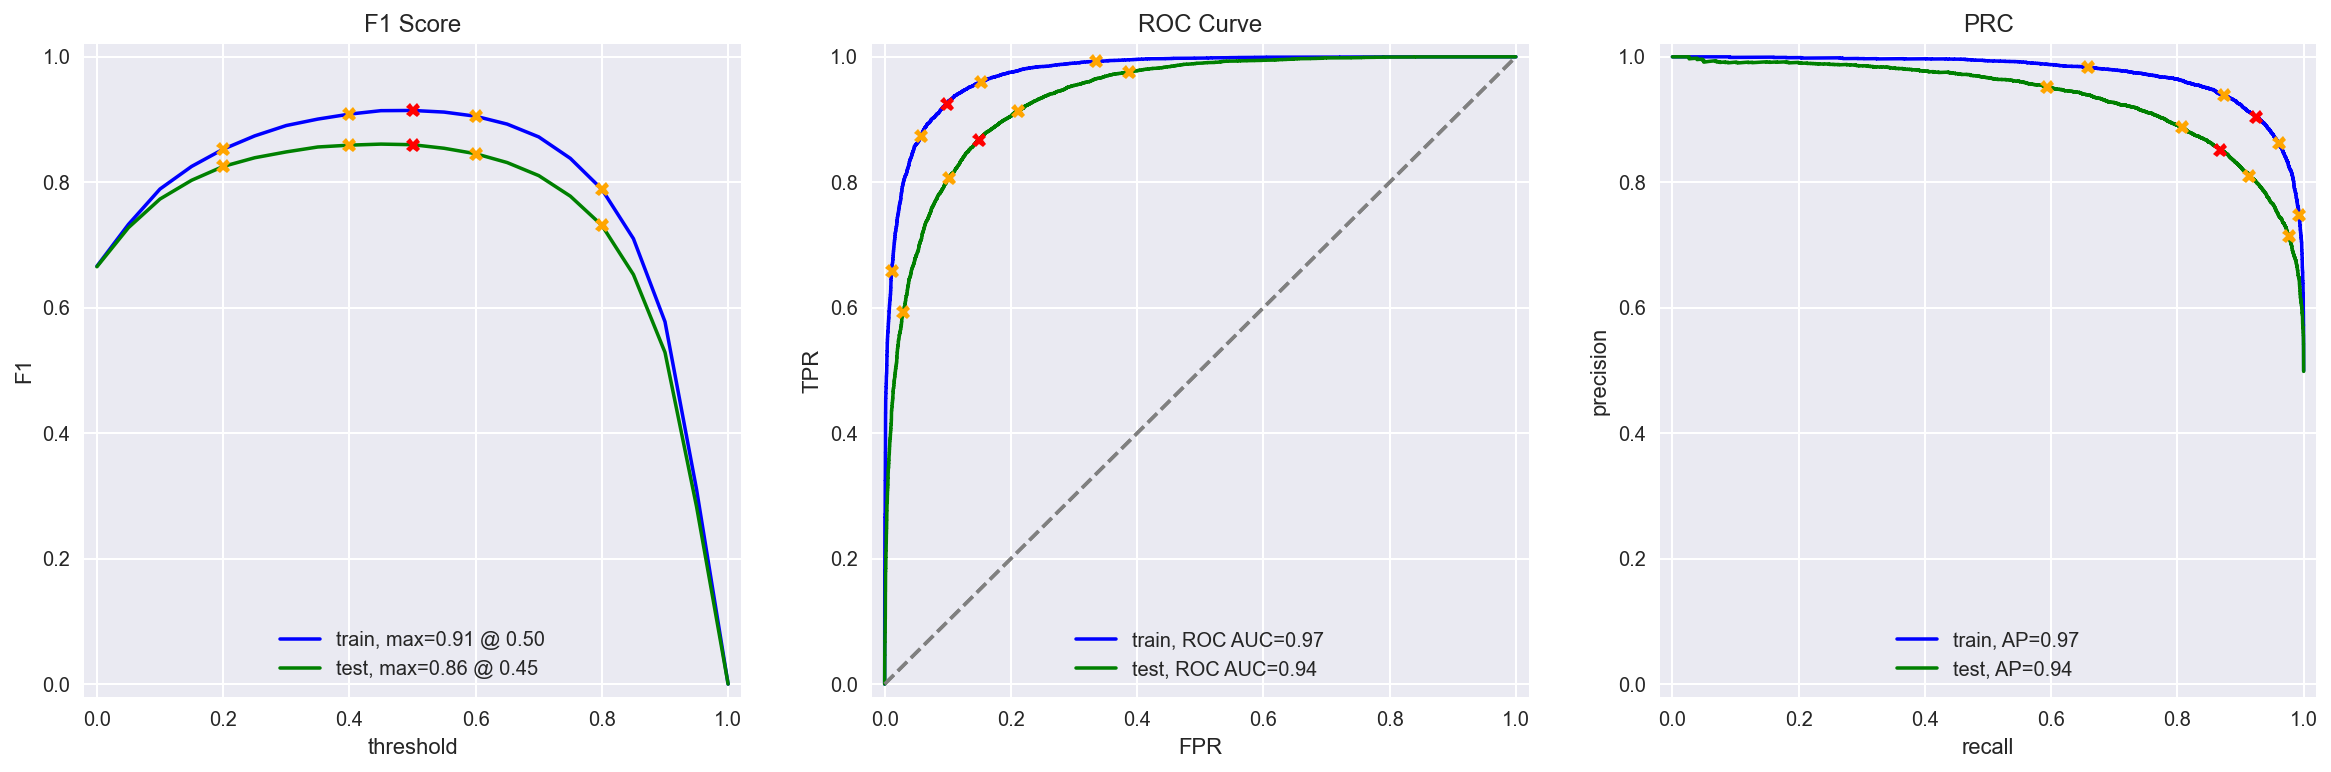

In [57]:
#evaluate model performance
evaluate_model(model_light_gbm, features_train_nltk, train_target, features_test_nltk, test_target)

          train  test
Accuracy   0.84  0.78
F1         0.85  0.80
APS        0.92  0.86
ROC AUC    0.93  0.87


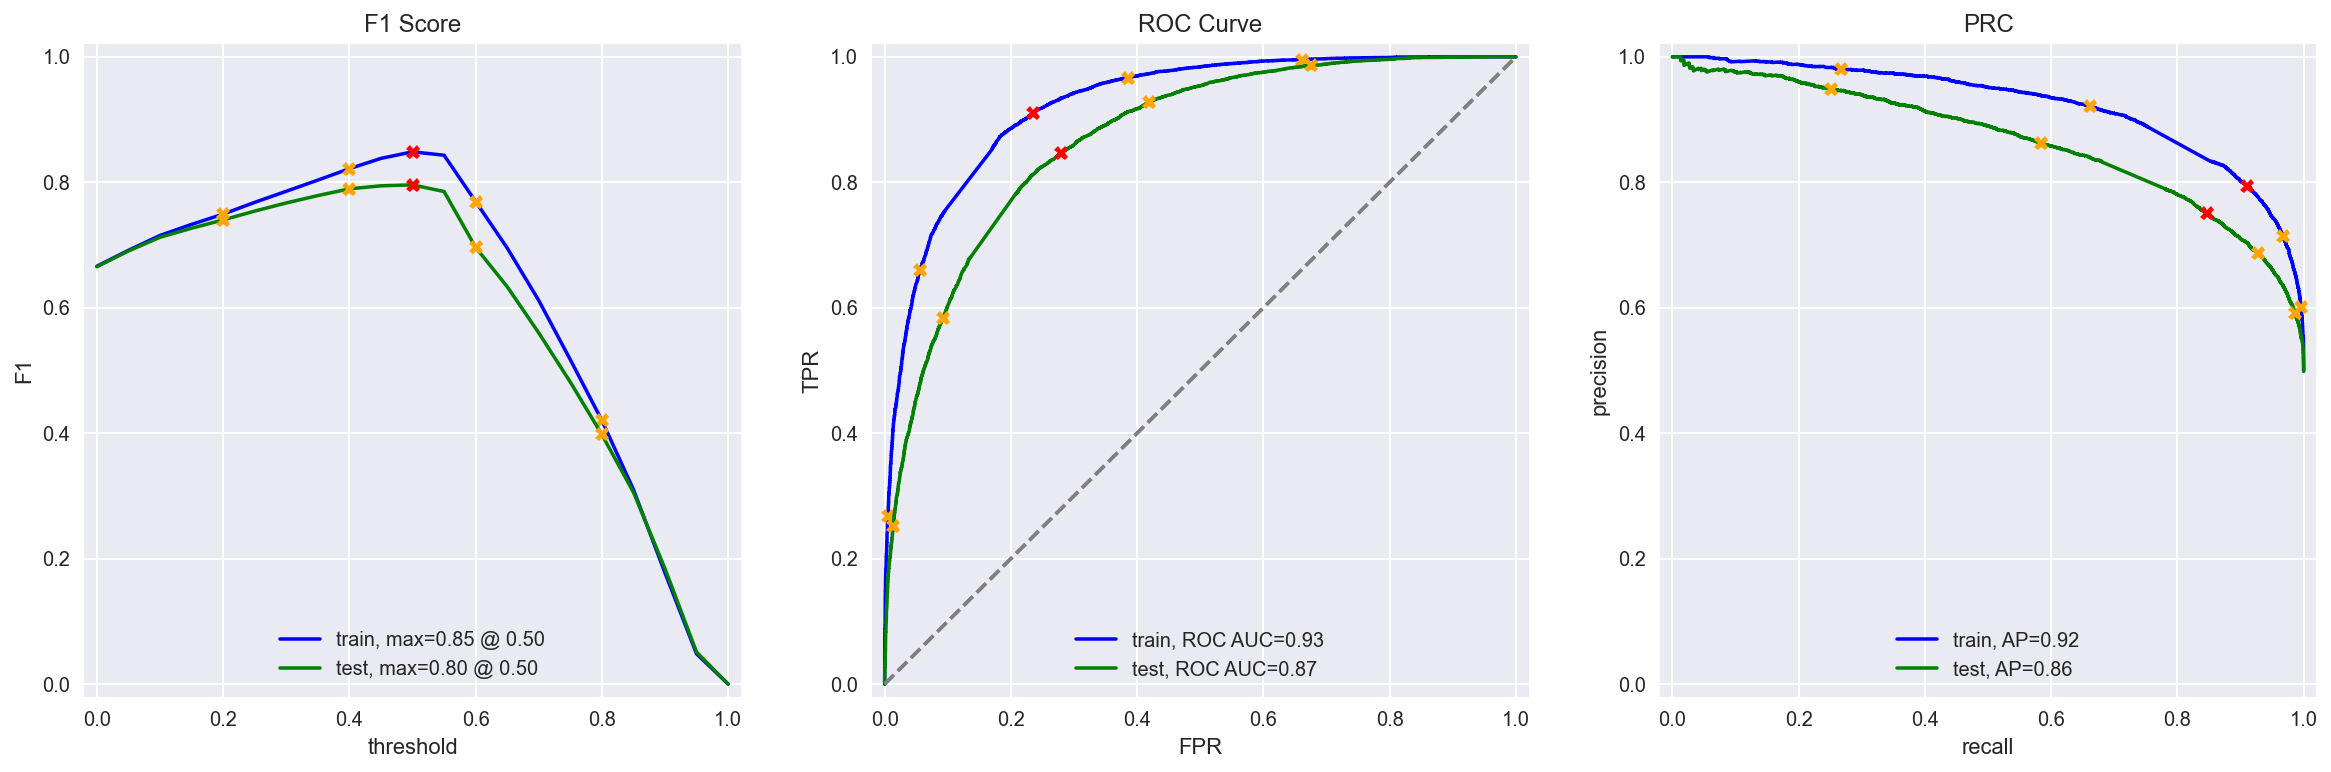

In [58]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_light_gbm, features_train_nltk_ngram, train_target, features_test_nltk_ngram, test_target)

### Model 3) NLTK, TF-IDF and XGB

In [59]:
#initialize model
model_xgboost= xgb.XGBClassifier()

          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


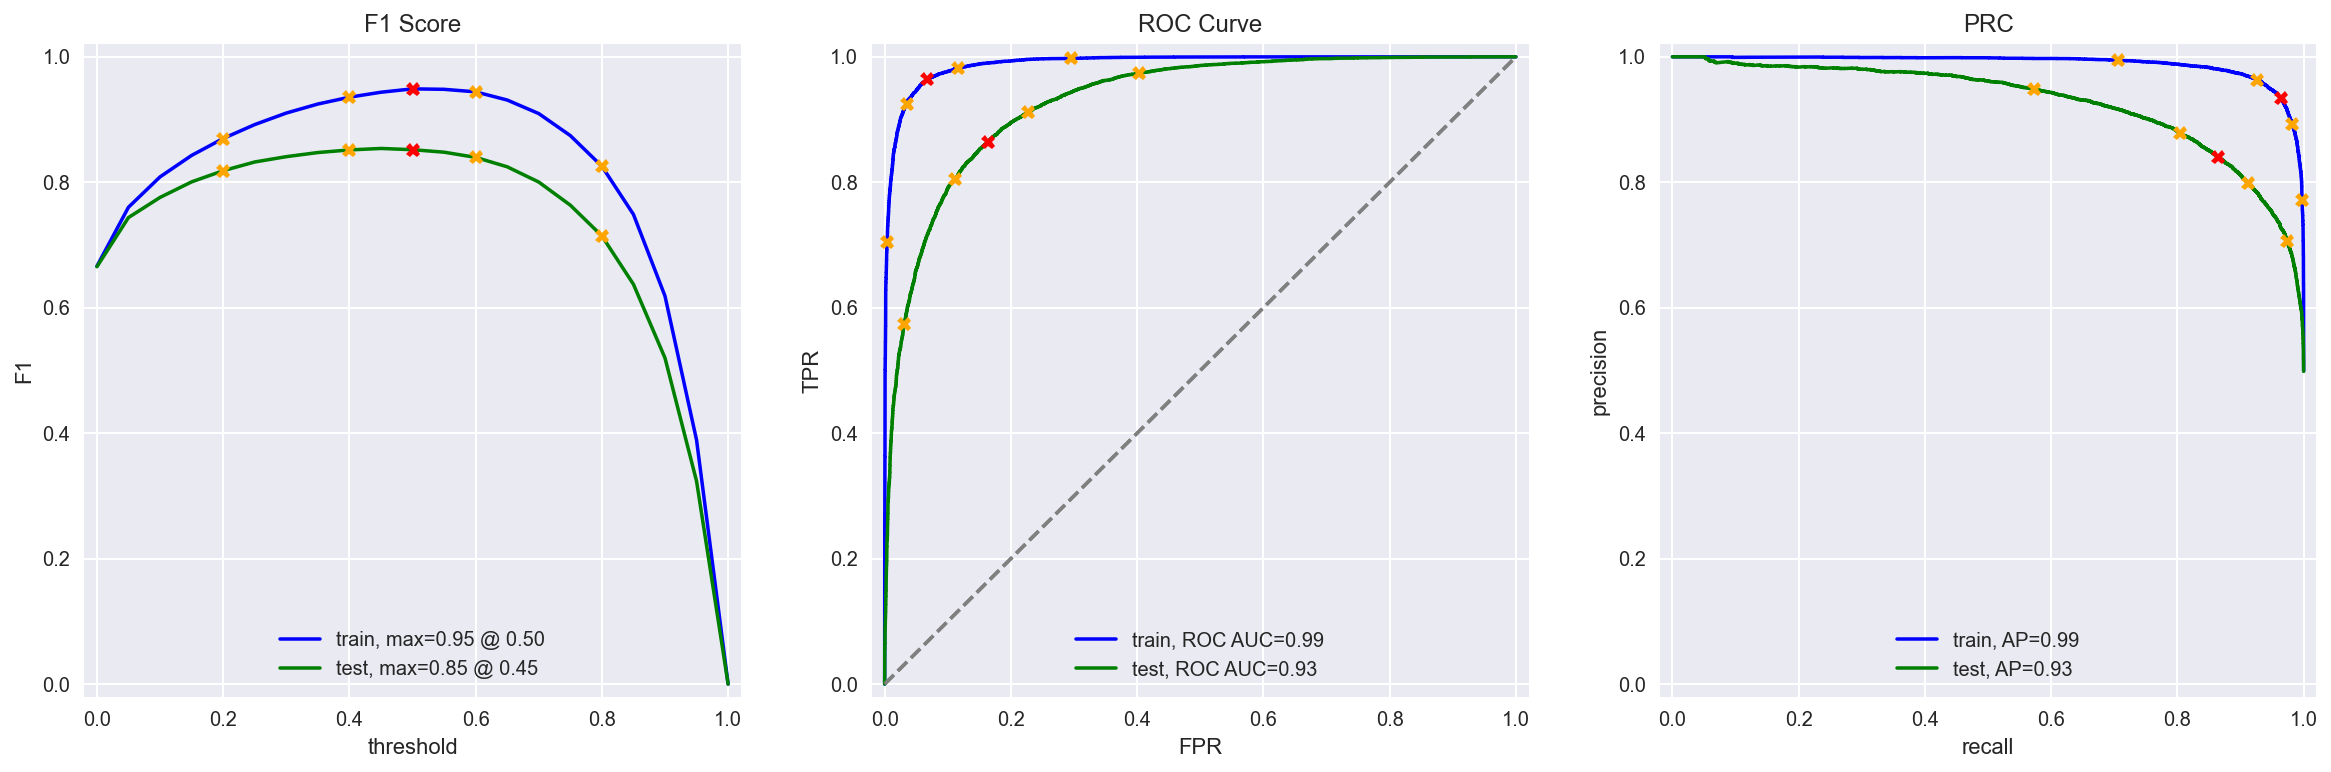

In [60]:
#evaluate model performance
evaluate_model(model_xgboost, features_train_nltk, train_target, features_test_nltk, test_target)

          train  test
Accuracy   0.82  0.76
F1         0.83  0.78
APS        0.90  0.83
ROC AUC    0.91  0.85


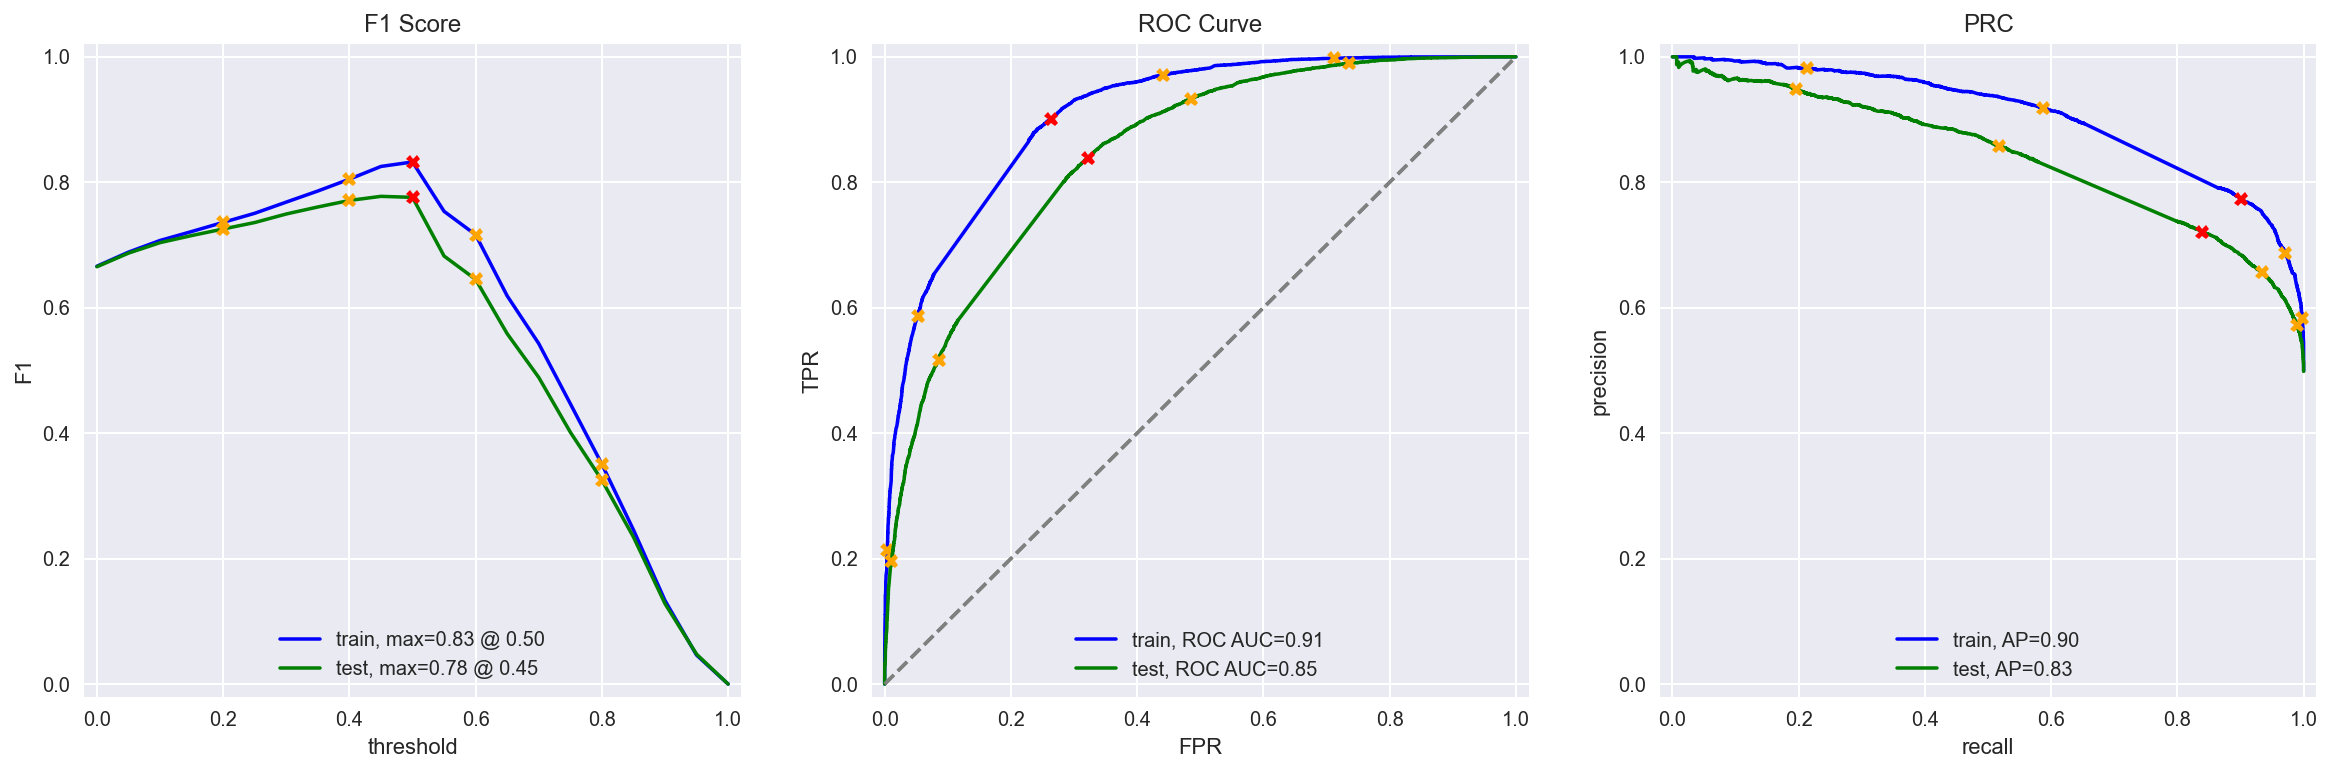

In [61]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_xgboost, features_train_nltk_ngram, train_target, features_test_nltk_ngram, test_target)

### NLTK - conclusion:

The best performing model was linear regression trained and tested on single words rather than pair of words (ngrams=(1,1)).

This model achieved a score of 0.94 on the train set, and 0.88 on the train set. Light GBM and XGBoost also managed to achieve  the 0.85 threshold based on the frequency of single words on NLTK-lemmatized reviews.

As for the result of the three models when setting ngrams to (2,2) [counting the frequency of pair of words instead of individually], all of them performed poorly on the test set. This is probably due to key pairs from the train set not repeating in the test set.

## spaCy & TF-IDF 

In [62]:
#initialize a lemmatizer 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#def function to lemmatize reviews

def spacy_lemmatize(text):
    

    
    #define stop words
    stopwords = nlp.Defaults.stop_words
    
    #lemmatize lowercase text
    doc=nlp(text.lower())
    
    #store each word from the lemmatized text in a list if the word is not a stopword
    lemmas= [token.lemma_ for token in doc if token not in stopwords]
    
    #return text joint with spaces
    return " ".join(lemmas)


In [63]:
#check that function works correctly 
spacy_lemmatize(clear_text(df.loc[1,'review']))

"how the hell do they get this make present itself as a caper comedy the misbegotten be essentially two hour of people mumble sentence fragment the usually dependable warren beatty look drunk and the usually hilarious goldie hawn act like she be on depressant as for gert frobe his most famous role goldfinger be infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness be I compare this movie to plan from outer space I would n't do such a thing even if someone pay I p fos be idiotically make but end up hilarious this be idiotically make and cause you to feel like your brain just melt out of your ear warren beatty and goldie hawn make up for this when they co star in shampoo but then they co star in the dreadful town country maybe they just should n't co star in movie all in all I would rather have my skin tear off than have to watch this again awful maybe they should remake it with jackie chan then I would p

In [64]:
%%time
#apply function to normalized reviews

df_train ['spacy_lemma']= df_train ['review_norm'].apply(spacy_lemmatize)
df_test ['spacy_lemma']= df_test ['review_norm'].apply(spacy_lemmatize)
df_train.head()

Wall time: 6min 38s


,tconst,start_year,average_rating,votes,review,rating,sp,pos,ds_part,review_norm,nltk_lemma,spacy_lemma
0,tt0068152,1971,6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,the pakage implies that warren beatty and gold...,pakage implies warren beatty goldie hawn pulli...,the pakage imply that warren beatty and goldie...
1,tt0068152,1971,6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,how the hell did they get this made presenting...,hell get made presenting caper comedy misbegot...,how the hell do they get this make present its...
7,tt0035958,1943,6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,this true story of carlson's raiders is more o...,true story carlson 's raider army training fil...,this true story of carlson 's raider be more o...
8,tt0035958,1943,6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,should have been titled 'balderdash ' little i...,titled 'balderdash ' little film true except n...,should have be title ' balderdash ' little in ...
9,tt0035958,1943,6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,the movie 'gung ho ' the story of carlson's ma...,movie 'gung ho ' story carlson 's makin island...,the movie ' gung ho ' the story of carlson 's ...


In [65]:
#store tf-idf of lemmatized text as features 
features_train_spacy, features_test_spacy= tf_idf(df_train ['spacy_lemma'], df_test ['spacy_lemma'])

#store tf-idf of pair of words from the lemmatized text as features 
features_train_spacy_ngram, features_test_spacy_ngram= tf_idf(df_train ['spacy_lemma'], df_test ['spacy_lemma'], rng=(2,2))

### Model 4) spaCy & TF-IDF  and LR

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


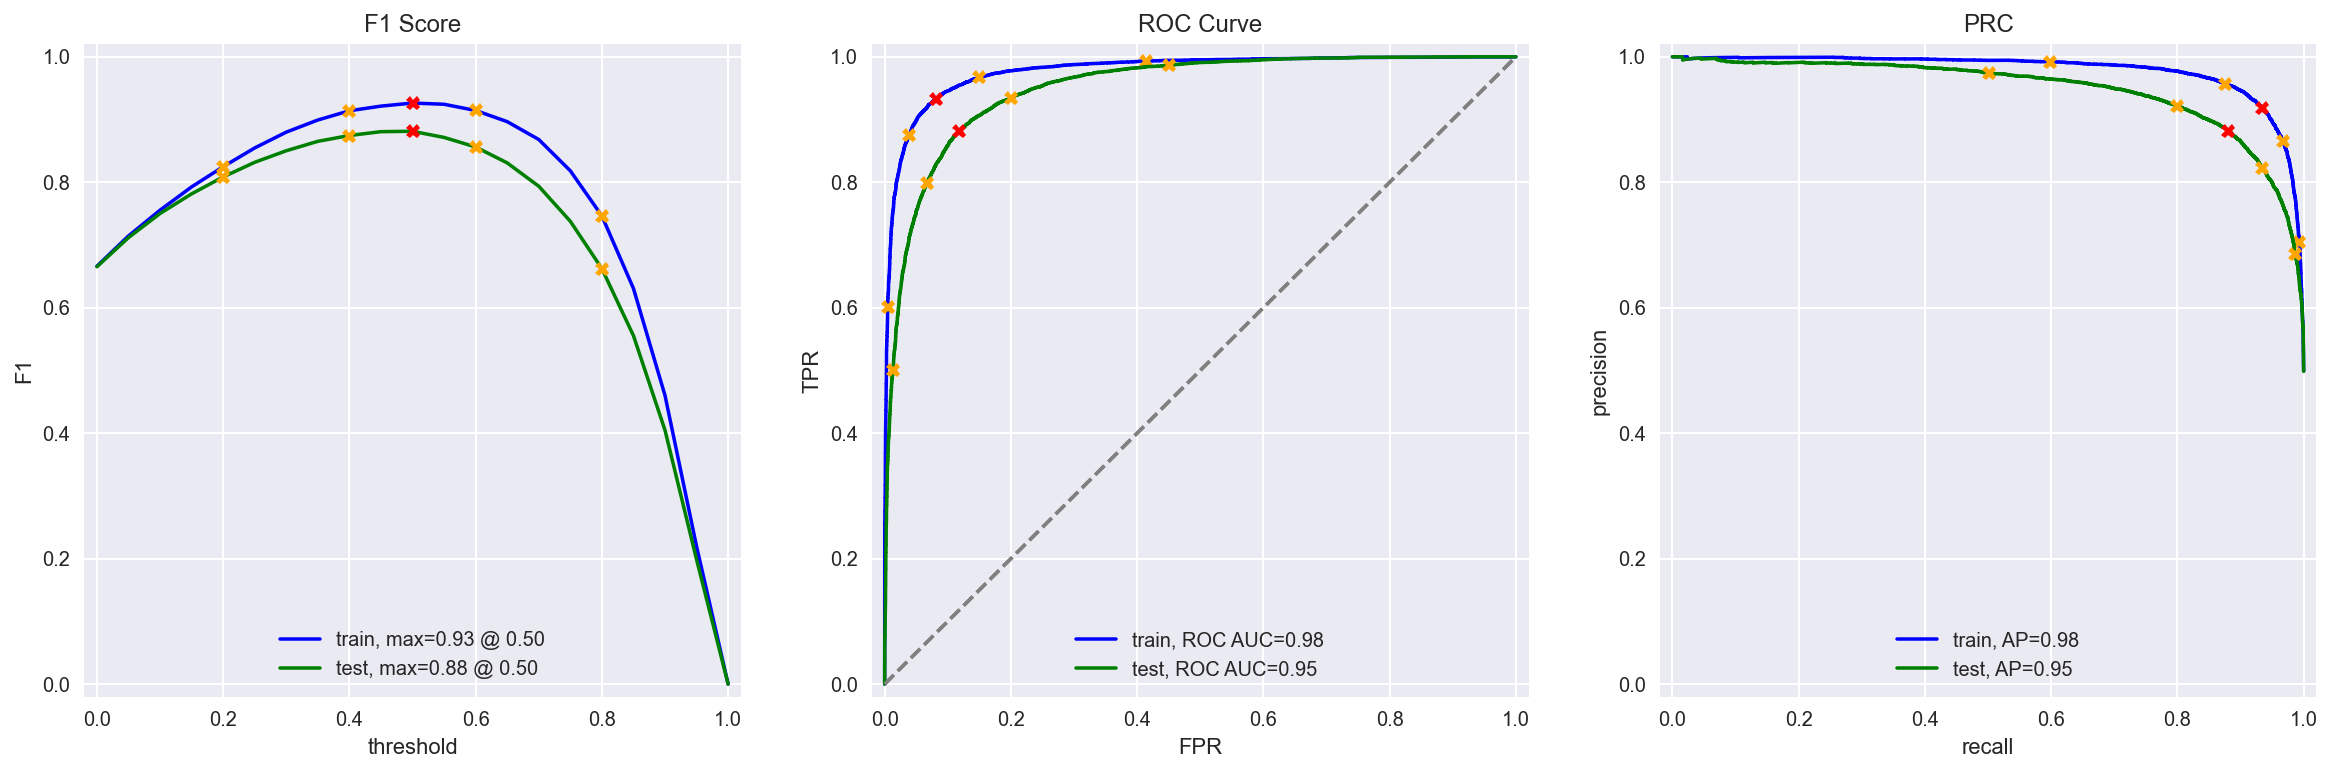

In [66]:
#evaluate model performance
evaluate_model(model_regression, features_train_spacy, train_target, features_test_spacy, test_target)

          train  test
Accuracy   0.97  0.87
F1         0.97  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


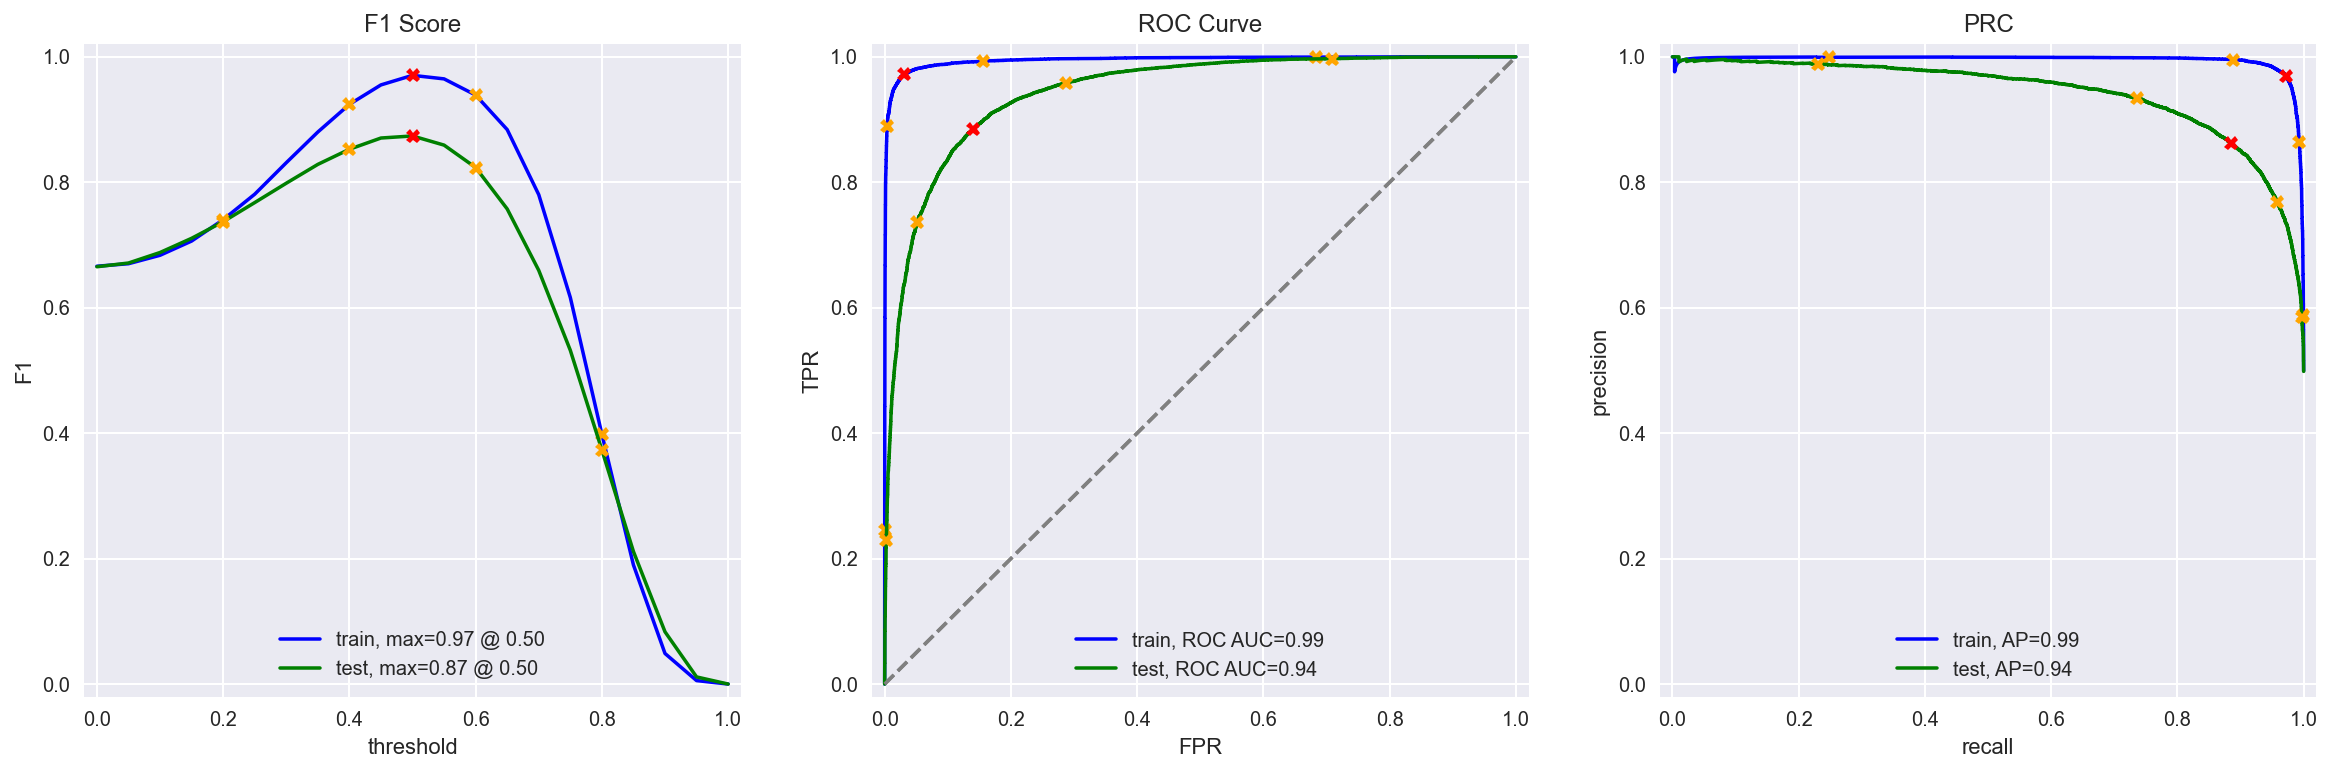

In [67]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_regression, features_train_spacy_ngram, train_target, features_test_spacy_ngram, test_target)

### Model 5) spaCy & TF-IDF  and LightGBM

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


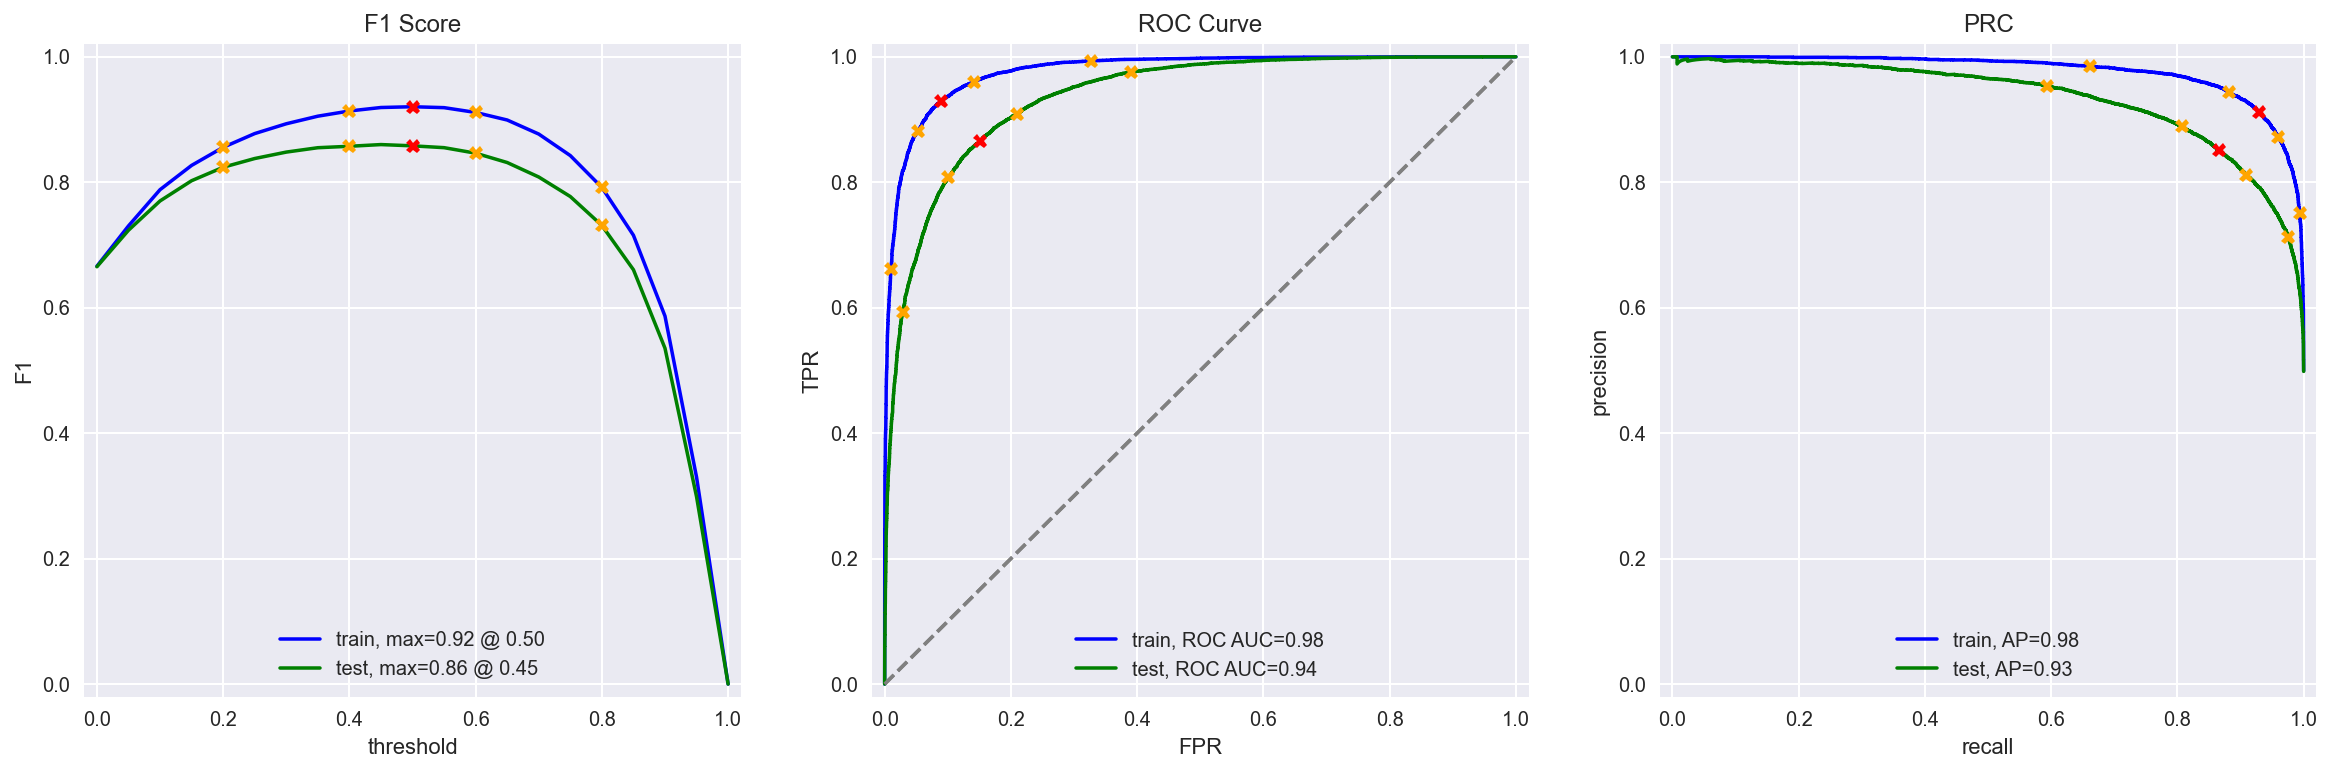

In [68]:
#evaluate model performance
evaluate_model(model_light_gbm, features_train_spacy, train_target, features_test_spacy, test_target)

          train  test
Accuracy   0.90  0.83
F1         0.90  0.84
APS        0.96  0.92
ROC AUC    0.97  0.92


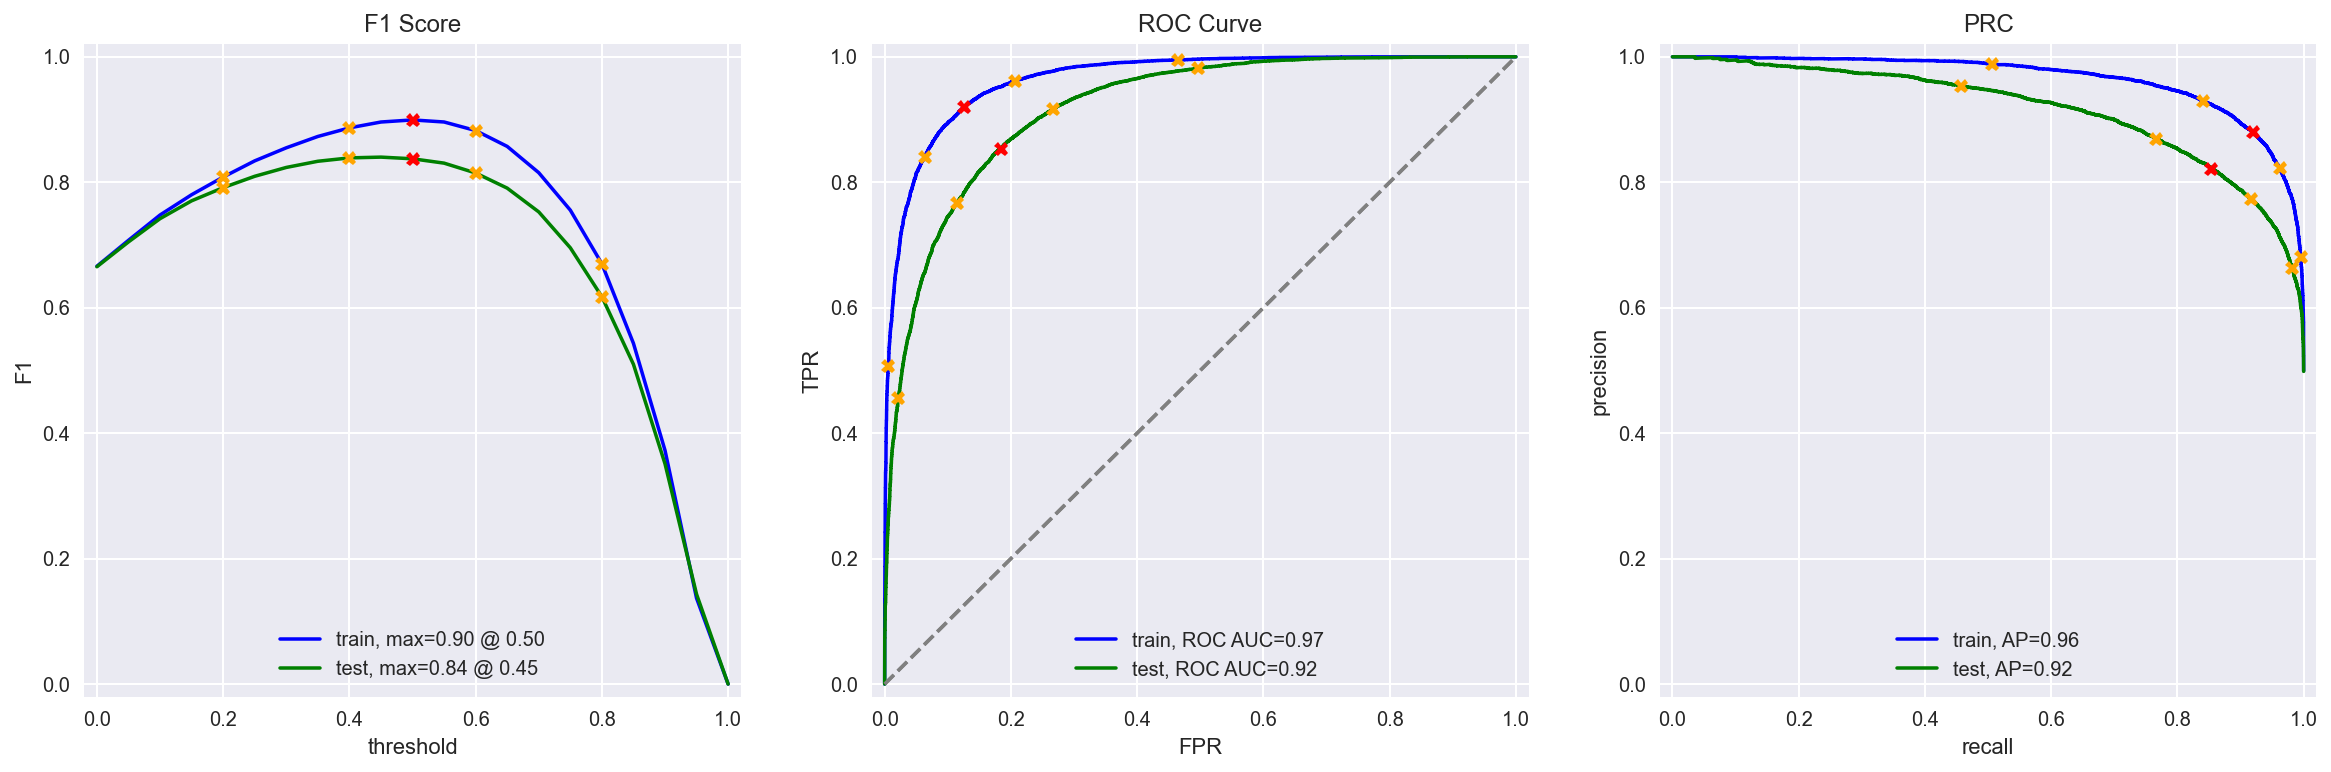

In [69]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_light_gbm, features_train_spacy_ngram, train_target, features_test_spacy_ngram, test_target)

### Model 6) spaCy & TF-IDF and XGB

          train  test
Accuracy   0.96  0.85
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


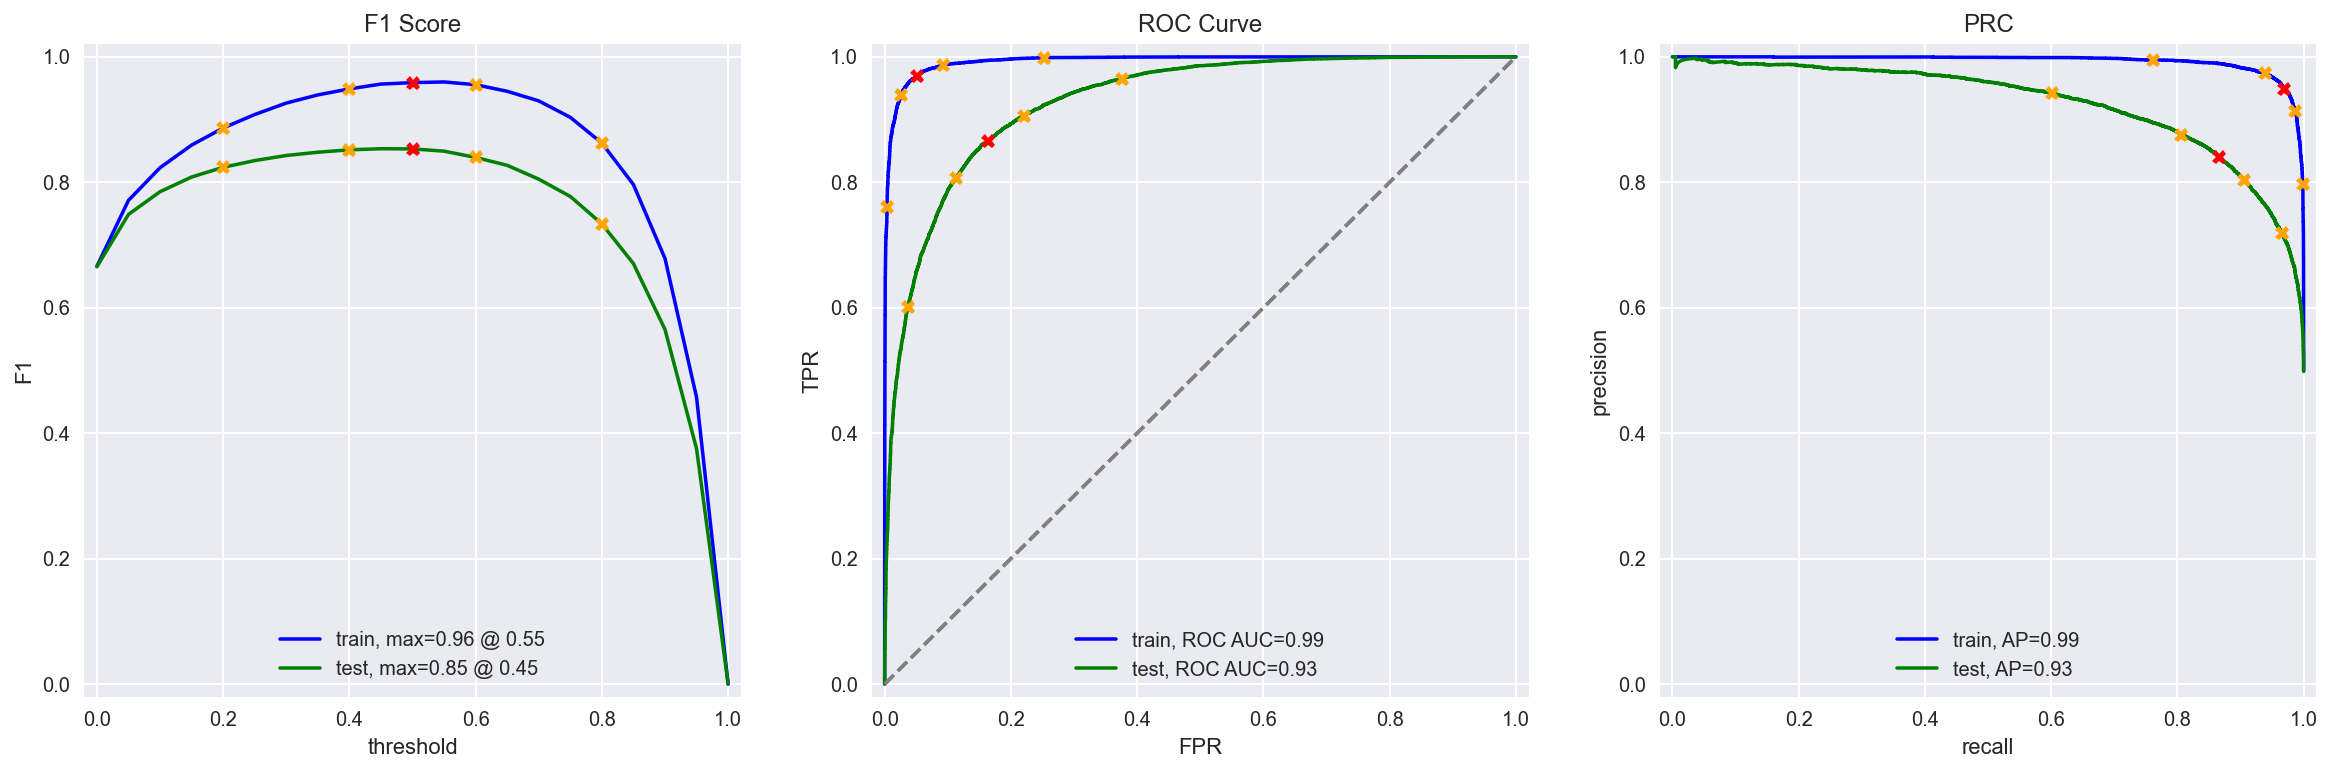

In [70]:
#evaluate model performance
evaluate_model(model_xgboost, features_train_spacy, train_target, features_test_spacy, test_target)

          train  test
Accuracy   0.92  0.82
F1         0.92  0.82
APS        0.98  0.90
ROC AUC    0.98  0.90


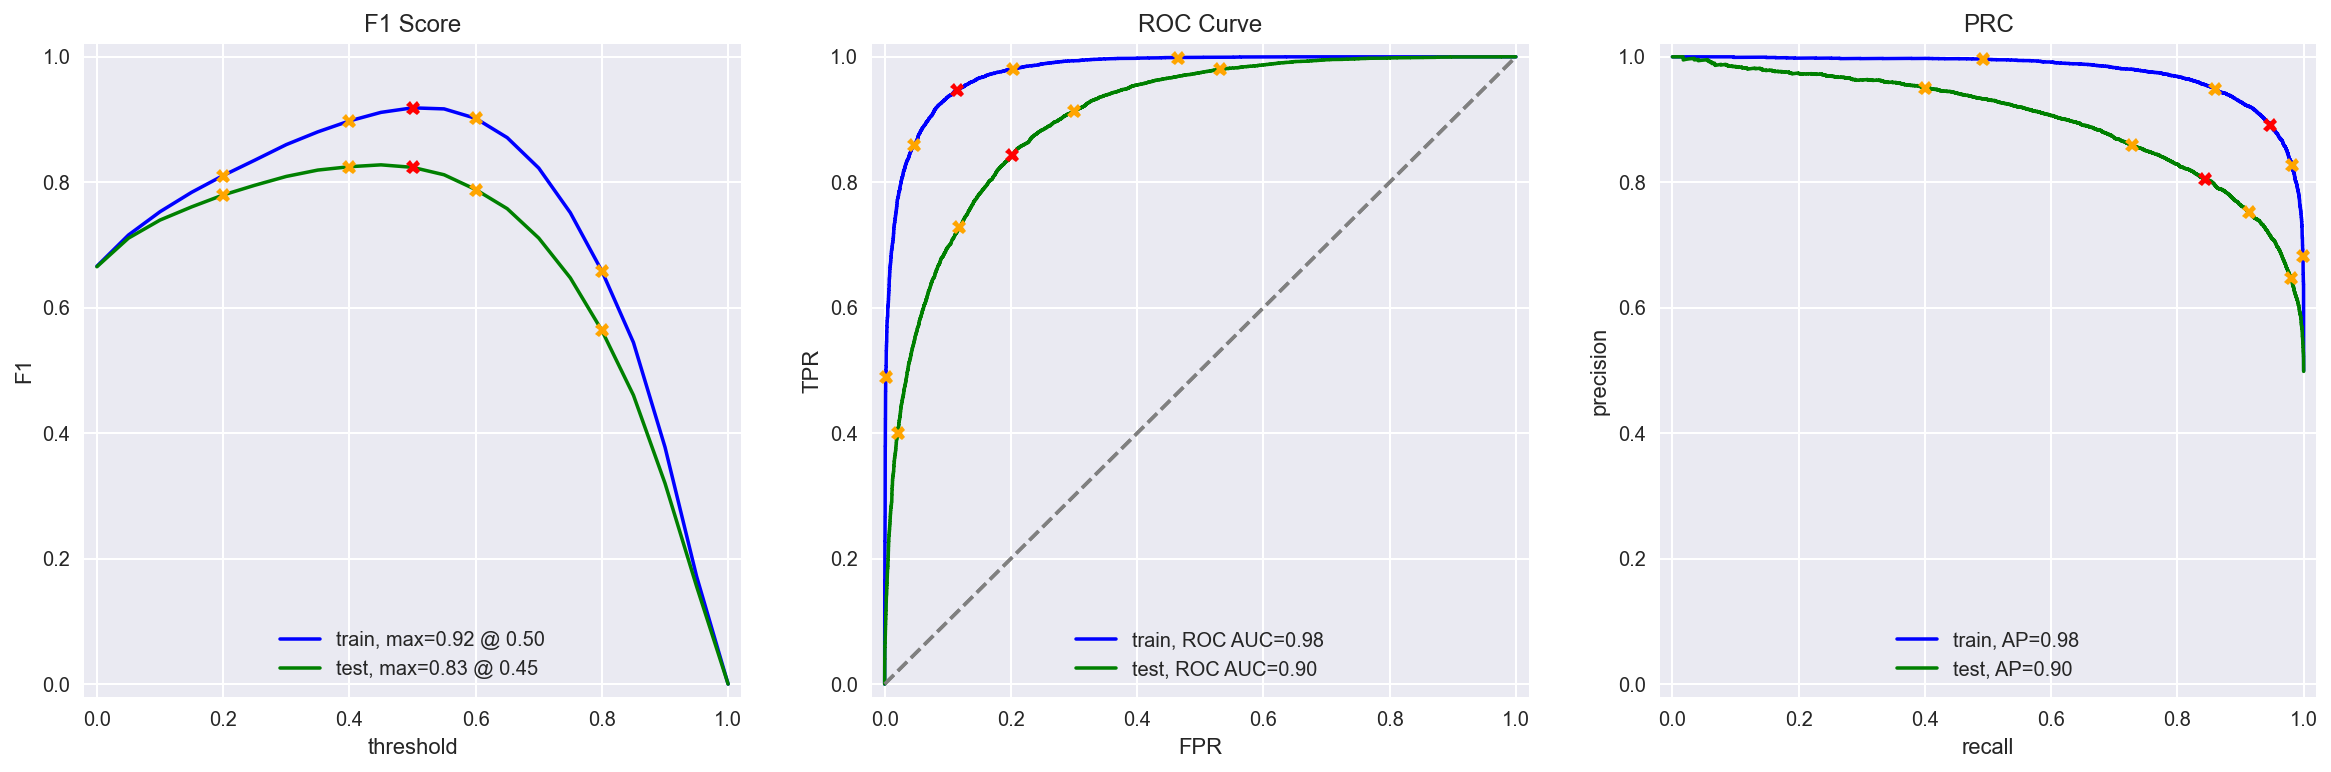

In [71]:
#evaluate model perfromance based on repetirtions of pair of words 
evaluate_model(model_xgboost, features_train_spacy_ngram, train_target, features_test_spacy_ngram, test_target)

### spaCy - conclusion:

The best performing model was linear regression again. It achieved a f1 score of 0.87 when trained and tested using word pairs frequency (ngrams=(2,2)) and of 0.88 with single words frequency count.

XGBooster and Light GBM got to the 0.85 mark with single words, but not with pairs of words.

As for the time it took spaCy to lemmatize words, we'd rather say that NLTK is a more efficient tool, as it took it 43 seconds to lemmatize all the reviews, whereas spaCy employed more than 6 minutes in performing the same task.

###  Model 7 - BERT

In [72]:
#import libraries
import torch
import transformers

In [73]:
#initialize bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

#configure transformer
config = transformers.BertConfig.from_pretrained('bert-base-uncased')

#initialize model
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    #empty lists as placeholders
    ids_list = []
    attention_mask_list = []
    
    
    
    # text to padded ids of tokens along with their attention masks
    
    # create ids_list and attention_mask_list
    for review in texts[:batch_size]:
        ids = tokenizer.encode(review.lower(), add_special_tokens=True, max_length=max_length, truncation=True)
        n = max_length
        padded = np.array(ids[:n] + [0]*(n - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # create attention_mask_batch
        attention_mask_batch= torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)   
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [75]:
#transformed features were exported in the first run of the script and will be imported below

# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_bert = BERT_text_to_embeddings(df_train['review_norm'], batch_size=750)

In [76]:
#transformed features were exported in the first run of the script and will be imported below

# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#test_features_bert = BERT_text_to_embeddings(df_test['review_norm'], batch_size=750)

In [77]:
#save converted features 
#np.savez_compressed('features_bert.npz', train_features_bert=train_features_bert, test_features_bert=test_features_bert)

In [78]:
#import converted features
with np.load('features_bert.npz') as data:
    test_features_bert = data['test_features_bert']
    train_features_bert = data['train_features_bert']

In [79]:
#get the first 750 values from the train target
train_target_bert= train_target[:750]

In [80]:
#get the first 750 values from the test target
test_target_bert= test_target[:750]

In [81]:
#compare shape of train features and train target
print(train_features_bert.shape)
print(train_target_bert.shape)

(750, 768)
(750,)


In [82]:
#compare shape of test features and train target
print(test_features_bert.shape)
print(test_target_bert.shape)

(750, 768)
(750,)


          train  test
Accuracy   0.99  0.83
F1         0.99  0.83
APS        1.00  0.91
ROC AUC    1.00  0.91


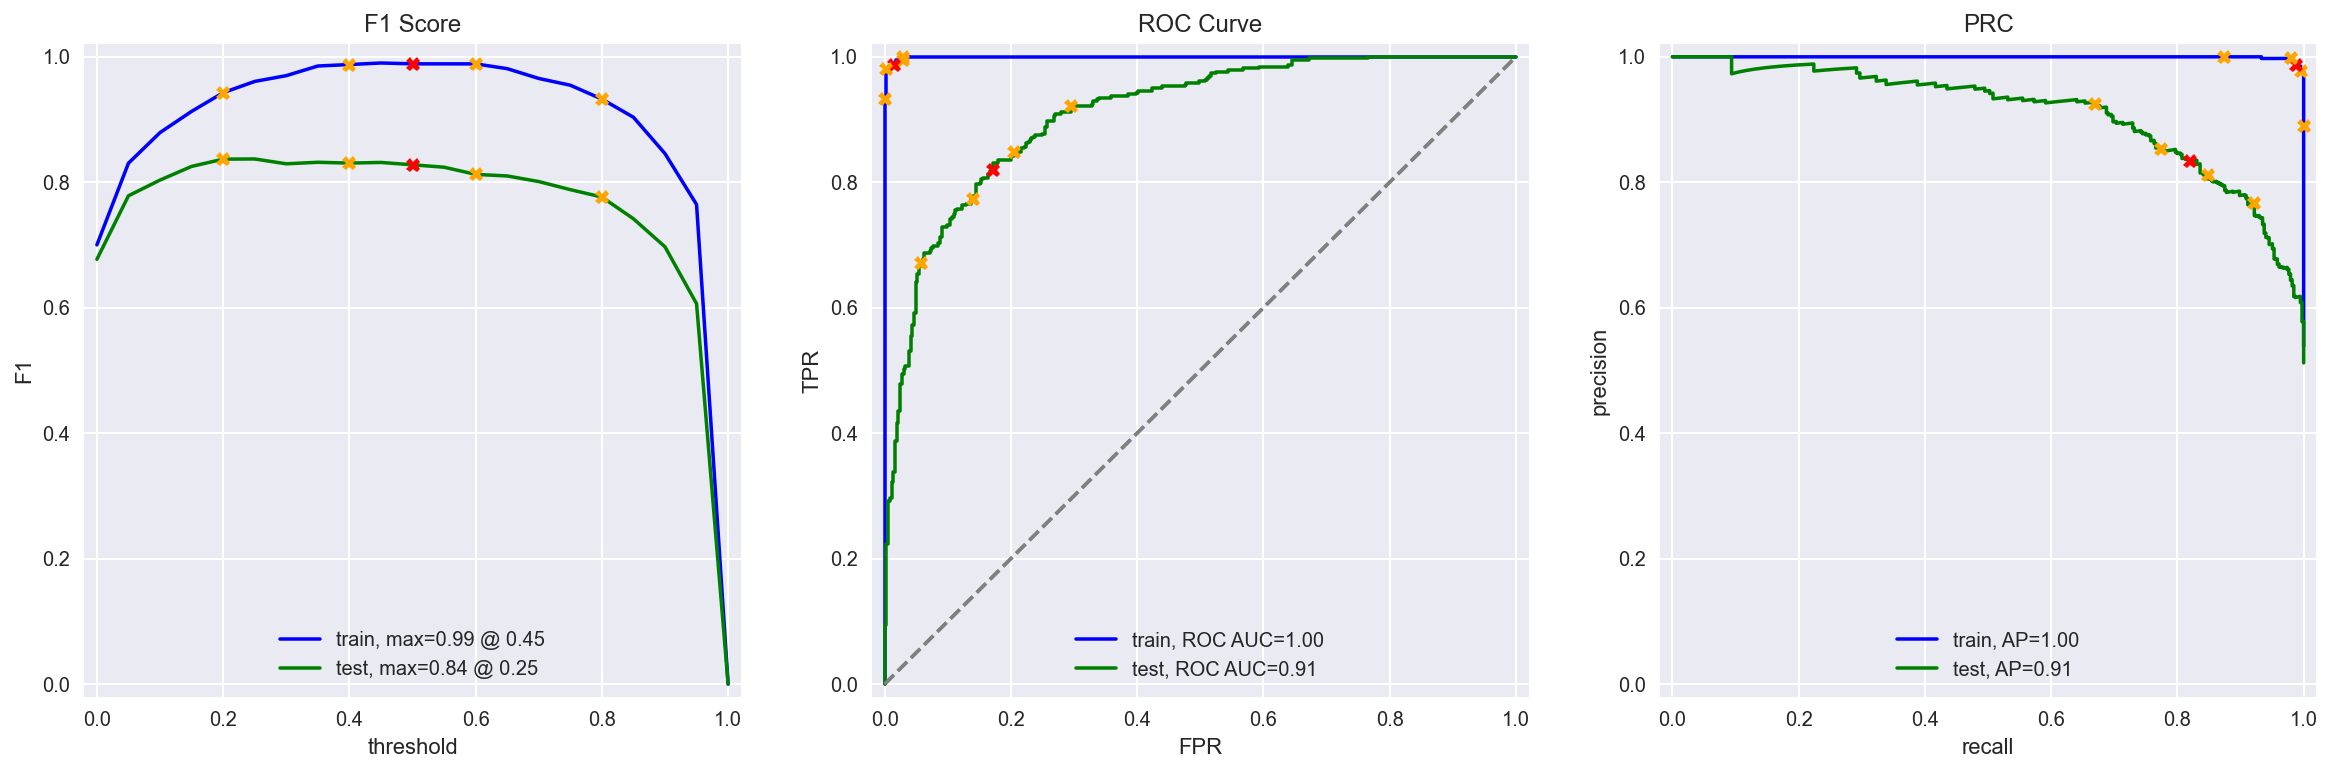

In [83]:
#evaluate regression model using bert
evaluate_model(model_regression, train_features_bert, train_target_bert,test_features_bert, test_target_bert)

          train  test
Accuracy    1.0  0.80
F1          1.0  0.81
APS         1.0  0.88
ROC AUC     1.0  0.88


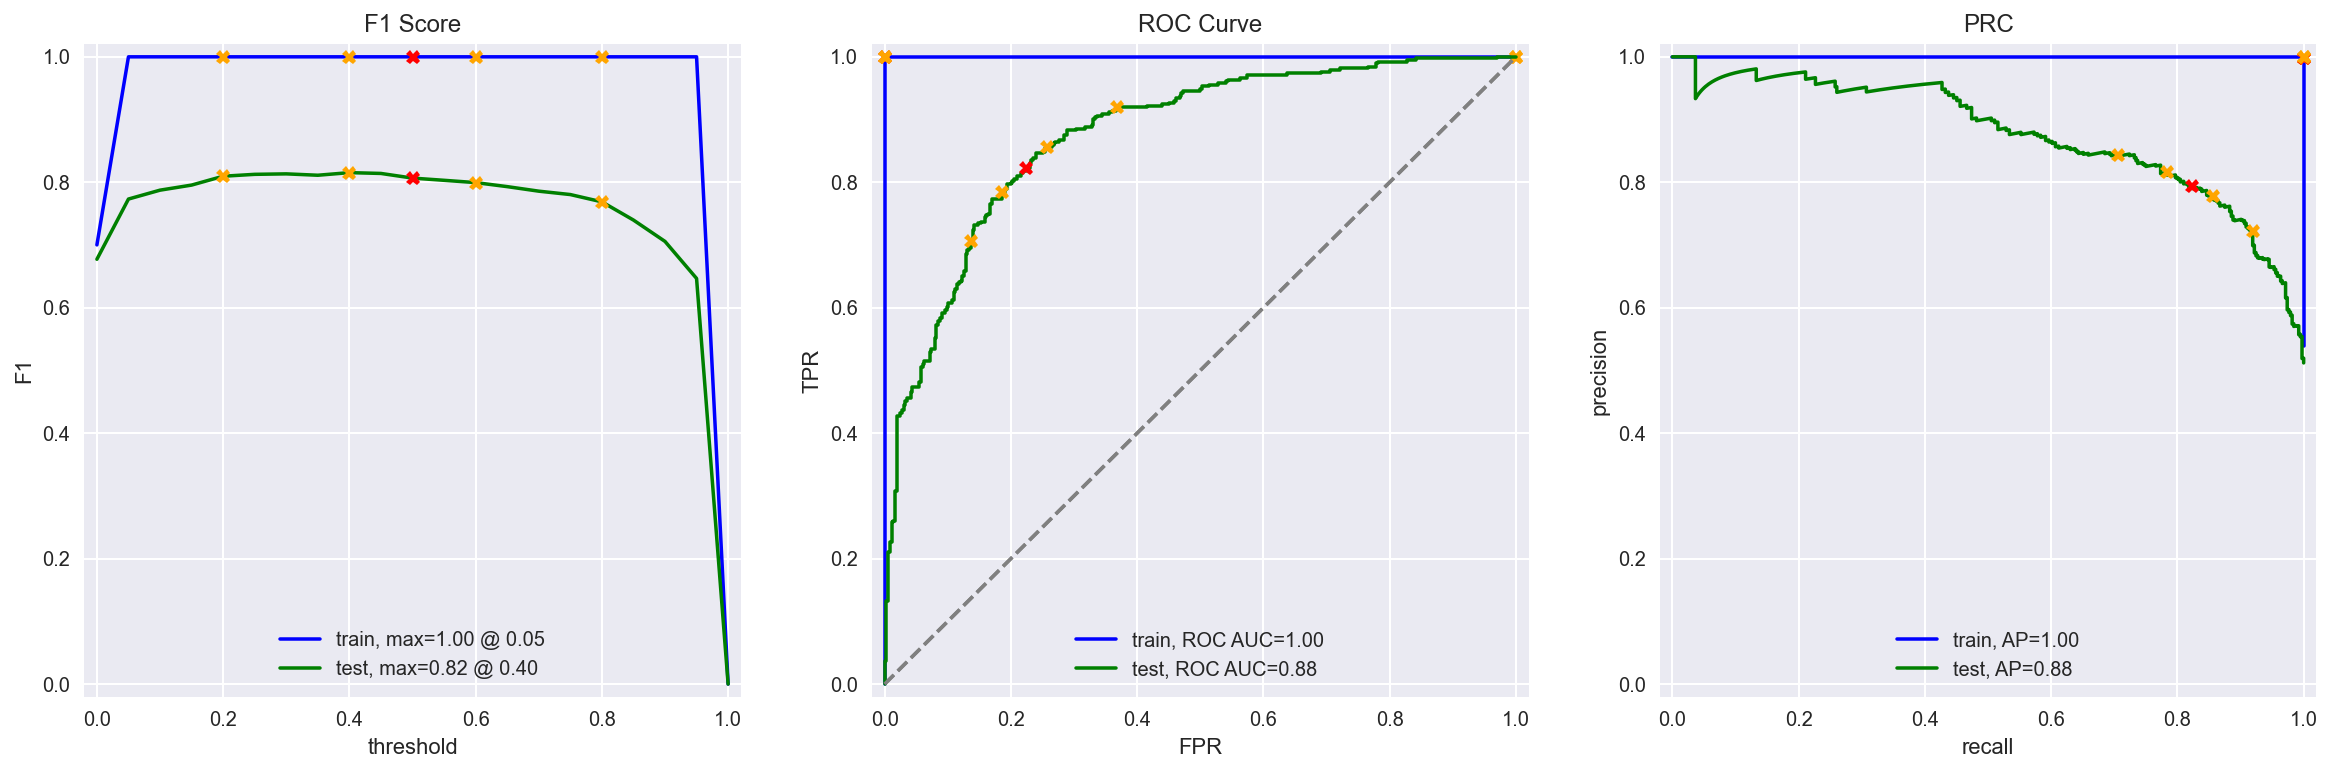

In [84]:
#evaluate Light GBM using bert
evaluate_model(model_light_gbm, train_features_bert, train_target_bert,test_features_bert, test_target_bert)

          train  test
Accuracy    1.0  0.79
F1          1.0  0.80
APS         1.0  0.89
ROC AUC     1.0  0.88


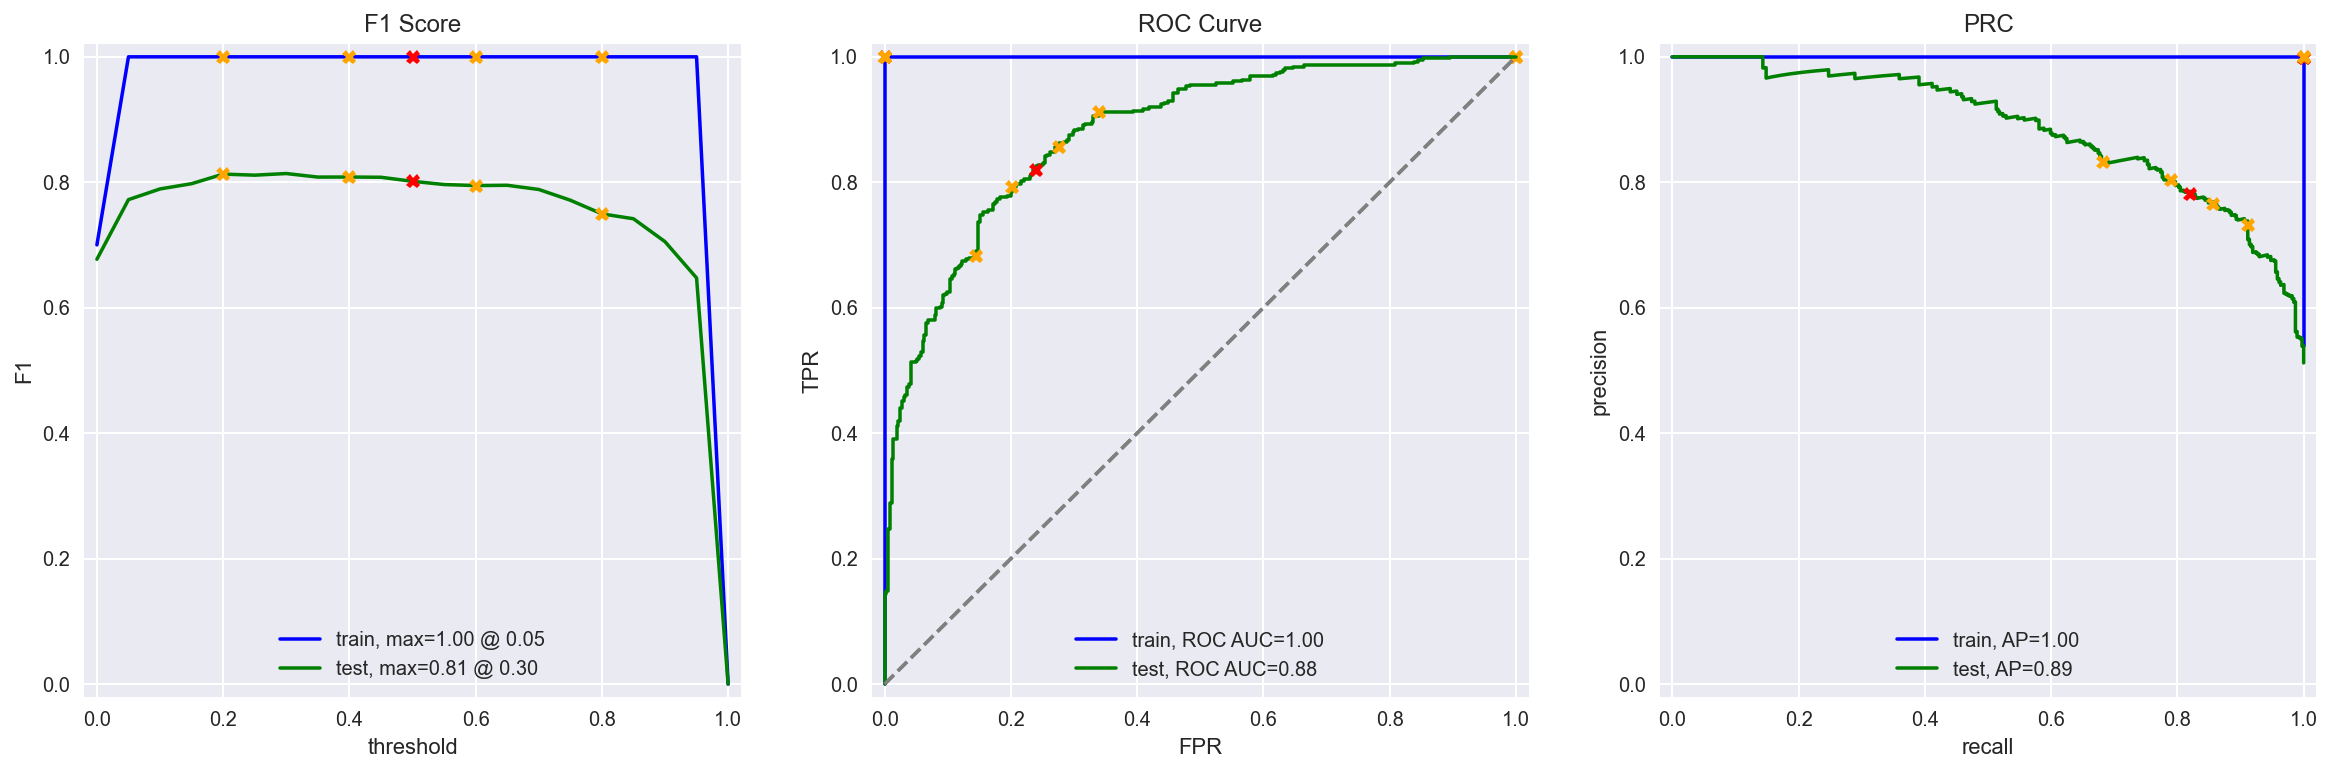

In [85]:

#Evaluate XGBoost using bert
evaluate_model(model_xgboost, train_features_bert, train_target_bert,test_features_bert, test_target_bert)

## Bert - Conclusion

None of the models managed to achieve a F1 score of 0.85 or greater on the test set using bert transformer, but we must bear in mind that they were trained and tested on a very small sample of reviews (750), what may have caused them not to see a sufficient variety of inputs at the time of adjusting their weights.

Judging from the scores achieved in the train set, we can say that Bert allows the models to accurately interpret keywords and their context to determine whether a review is good or bad, but probably the reviews in the train set were not that similar to the ones in the test set, and that's why the models underperformed, as explained before.

## My Reviews

Below, we will take a look to how each lemmatizer modifies reviews, and how each model classifies them into positive or negative, to see what makes models be more successful at this task than others.

Since the models have prooved to perform better without ngrams, we won't apply that to the counter.


In [86]:
# Define a df with random reviews
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

#normalize reviews (remove special characters, numbers, double spaces)
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1: NLTK, TF-IDF and LR

In [87]:

#lemmatize with NLTK
my_reviews['nltk_lemma'] = my_reviews['review_norm'].apply(nltk_lemmatize)

#convert with counter
x, texts_tfidf_nltk= tf_idf(df_train ['nltk_lemma'], my_reviews['nltk_lemma'])

#fit nltk lemmatized train set again
model_regression.fit(features_train_nltk, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_linear = model_regression.predict_proba(texts_tfidf_nltk)[:, 1]


#Print the probability and the review
for i, review in enumerate( my_reviews['nltk_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_linear[i]:.2f} ({round(my_reviews_pred_prob_linear[i])}):  {review}')

P=0.15 (0):  simply like kind movie
P=0.16 (0):  well bored felt asleep middle movie
P=0.55 (1):  really fascinated movie
P=0.11 (0):  even actor looked really old disinterested got paid movie soulless cash grab
P=0.28 (0):  n't expect reboot good writer really cared source material
P=0.51 (1):  movie upside downside feel like overall 's decent flick could see going see
P=0.04 (0):  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
P=0.88 (1):  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 2) NLTK, TF-IDF and Light GBM

In [88]:
#fit nltk lemmatized train set again
model_light_gbm.fit(features_train_nltk, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_lgbm = model_light_gbm.predict_proba(texts_tfidf_nltk)[:, 1]

#Print the probability and the review
for i, review in enumerate( my_reviews['nltk_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_lgbm[i]:.2f} ({round(my_reviews_pred_prob_lgbm[i])}):  {review}')

P=0.56 (1):  simply like kind movie
P=0.56 (1):  well bored felt asleep middle movie
P=0.59 (1):  really fascinated movie
P=0.32 (0):  even actor looked really old disinterested got paid movie soulless cash grab
P=0.60 (1):  n't expect reboot good writer really cared source material
P=0.51 (1):  movie upside downside feel like overall 's decent flick could see going see
P=0.23 (0):  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
P=0.72 (1):  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 3) NLTK, TF-IDF and XGB

In [89]:
#fit nltk lemmatized train set again
model_xgboost.fit(features_train_nltk, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_xgb = model_xgboost.predict_proba(texts_tfidf_nltk)[:, 1]

#Print the probability and the review
for i, review in enumerate( my_reviews['nltk_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_xgb[i]:.2f} ({round(my_reviews_pred_prob_xgb[i])}):  {review}')

P=0.57 (1):  simply like kind movie
P=0.55 (1):  well bored felt asleep middle movie
P=0.60 (1):  really fascinated movie
P=0.42 (0):  even actor looked really old disinterested got paid movie soulless cash grab
P=0.53 (1):  n't expect reboot good writer really cared source material
P=0.62 (1):  movie upside downside feel like overall 's decent flick could see going see
P=0.29 (0):  rotten attempt comedy single joke land everyone act annoying loud even kid wo n't like
P=0.68 (1):  launching netflix brave move really appreciate able binge episode episode exciting intelligent new d


### Model 4) spaCy & TF-IDF  and LR

In [90]:
#lemmatize with SPACY
my_reviews['spacy_lemma'] =my_reviews['review_norm'].apply(spacy_lemmatize)

#convert with counter
x, texts_tfidf_spacy= tf_idf(df_train ['spacy_lemma'], my_reviews['spacy_lemma'])

#fit spaCy lemmatized train set again
model_regression.fit(features_train_spacy, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_linear_spacy = model_regression.predict_proba(texts_tfidf_spacy)[:, 1]

#Print the probability and the review
for i, review in enumerate( my_reviews['spacy_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_linear_spacy[i]:.2f} ({round(my_reviews_pred_prob_linear_spacy[i])}):  {review}')

P=0.18 (0):  I do not simply like it not my kind of movie
P=0.22 (0):  well I be bored and feel asleep in the middle of the movie
P=0.47 (0):  I be really fascinated with the movie
P=0.14 (0):  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
P=0.21 (0):  I do n't expect the reboot to be so good writer really care about the source material
P=0.66 (1):  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
P=0.04 (0):  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
P=0.86 (1):  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Model 5) spaCy & TF-IDF  and Light GBM

In [91]:

#fit spaCy lemmatized train set again
model_light_gbm.fit(features_train_spacy, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_lgbm_spacy = model_light_gbm.predict_proba(texts_tfidf_spacy)[:, 1]

#Print the probability and the review
for i, review in enumerate( my_reviews['spacy_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_lgbm_spacy[i]:.2f} ({round(my_reviews_pred_prob_lgbm_spacy[i])}):  {review}')

P=0.52 (1):  I do not simply like it not my kind of movie
P=0.54 (1):  well I be bored and feel asleep in the middle of the movie
P=0.60 (1):  I be really fascinated with the movie
P=0.56 (1):  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
P=0.58 (1):  I do n't expect the reboot to be so good writer really care about the source material
P=0.78 (1):  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
P=0.22 (0):  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
P=0.72 (1):  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Model 6) spaCy & TF-IDF  and XGBoost




In [92]:
#fit spaCy lemmatized train set again
model_xgboost.fit(features_train_spacy, train_target)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_xgb_spacy = model_xgboost.predict_proba(texts_tfidf_spacy)[:, 1]

#Print the probability and the review
for i, review in enumerate( my_reviews['spacy_lemma'].str.slice(0, 100)):
    print(f'P={my_reviews_pred_prob_xgb_spacy[i]:.2f} ({round(my_reviews_pred_prob_xgb_spacy[i])}):  {review}')

P=0.59 (1):  I do not simply like it not my kind of movie
P=0.37 (0):  well I be bored and feel asleep in the middle of the movie
P=0.64 (1):  I be really fascinated with the movie
P=0.55 (1):  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
P=0.69 (1):  I do n't expect the reboot to be so good writer really care about the source material
P=0.82 (1):  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
P=0.35 (0):  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
P=0.79 (1):  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Model 7) Bert and LR

In [93]:
#embed with bert
my_reviews_features_bert = BERT_text_to_embeddings(my_reviews['review_norm'], disable_progress_bar=True)

#train regression model with bert transformed train features
model_regression.fit( train_features_bert, train_target_bert)

#Store the probabilitiy the model assigns to each review 
my_reviews_pred_prob_bert = model_regression.predict_proba(my_reviews_features_bert)[:, 1]

#Print the probability and the review
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_bert[i]:.2f} ({round(my_reviews_pred_prob_bert[i])}):  {review}')

0.28 (0):  i did not simply like it not my kind of movie
0.01 (0):  well i was bored and felt asleep in the middle of the movie
0.90 (1):  i was really fascinated with the movie
0.00 (0):  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.38 (0):  i didn't expect the reboot to be so good writers really cared about the source material
0.93 (1):  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.02 (0):  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.97 (1):  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusions

After loading and pre-processing data, we used the "review" column to train and test the performance of three different models, using TF-IDF with two different lemmatizers (NLTK and spaCy), applying ngrams= (2,2) to count word pairs, and also counting words individually.

Then we evaluated models performance on 750 reviews from each set, transformed using BERT language representation.

The results were as follows:

- Logistic regression, Light GBM and XGBoost were able to get the 0.85 f1 score expected using either NLTK or spaCy for text lemmatizing, and not taking words in pairs, but individually.

- None of the models achieved the target score using ngrams (frequency of word pairs) with NLTK, but logistic regression did so with spaCy lemmatized text.

- NLTK was considerably quicker to lemmatize reviews as compared to spaCy, and both achieved the same maximum F1 score (0.88 using logistic regression).

- BERT scored outsandingly well in the train set but performed poorly on the test set. This is probably the consequence of us not being able to run it on the entire sets, and having to only select 750 samples from each of them, due to how resource consuming the model is.

- From the classification of self-written reviews, we can conclude that:
 
 - NLTK simplifies text a bit more than spaCy, as the latter's processed reviews are longer.
 - Logistic regression assigns probabilities better than gradient boosters, and when using NLTK it correctly classified almost every review (except for the 5th, which was a false negative). When using spaCy, it failed to detect the third review as positive, but the probability assigned was really close to the 50%.
 - XGBooster and Light GBM were correct on negative predictions, but issued many false positives for reviews that actually had a negative connotation.
 - BERT kept verbal tenses instead of taking words to their root form. Every review but the fifth one was correctly classified as well as with logistic regression. We can attribute such failure to the "didn't" at the beginning of the sentence.
 
 
 
To wrap up, we'd say that if we had to choose the best tools to run this project, we'd use NLTK for lemmatizing reviews, and train a logistic regression model, as it was the one that achieved the greatest F1 score on the test set.

As for models training and predictions making time, there weren't relevant differences between regression and gradient boosting models.
 
 


